**Projet 6 : Classifiez automatiquement des biens de consommation**

* Consignes : https://openclassrooms.com/fr/projects/631/assignment
* Données : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip
* Documentation API Amazon : https://docs.aws.amazon.com/fr_fr/AWSECommerceService/latest/DG/ItemSearch.html

**Etude de faisabilité du moteur de classification**

Votre mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

Pour ce faire, vous allez évaluer la possibilité d'extraire des données depuis l'API Amazon en prenant connaissance de la documentation et en écrivant la requête qui vous permettrait d'extraire des données supplémentaires. Vous vous assurerez ainsi que vous pourrez bien disposer de plus de données et diversifier les sources de données pour éviter les biais pour votre moteur de classification.

**Contraintes**

Linda vous a communiqué les contraintes suivantes :

* Limiter le nombre d’articles pris par l’API (par exemple : 1000 lignes) et filtrer sur un unique type d’article (par exemple un type d’article peu présent dans votre échantillon de données actuelles).
* Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.
* Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.


# Chargement et nettoyage

**Imports**

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #opencv pour SIFT


pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

import time

In [42]:
data = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

In [43]:
data.shape

(1050, 15)

In [44]:
data.sample(3)

uniq_id            crawl_timestamp  \
117  be09f5a3a88ac10ae14c791fc8ac0dae  2016-01-03 09:39:44 +0000   
381  079d049de21fb2426b516a8d2f9a8bdb  2015-12-01 06:13:00 +0000   
278  553aa0252537751d153e7c50029f0242  2016-04-24 18:34:50 +0000   

                                           product_url  \
117  http://www.flipkart.com/anthill-baby-boy-s-gir...   
381  http://www.flipkart.com/envy-1000-intense-magn...   
278  http://www.flipkart.com/adino-adf04-analog-wat...   

                                 product_name  \
117  Anthill Baby Boy's, Baby Girl's Bodysuit   
381      Envy 1000 Intense,Magnetic Combo Set   
278     Adino ADF04 Analog Watch  - For Girls   

                                 product_category_tree               pid  \
117  ["Baby Care >> Infant Wear >> Baby Boys' Cloth...  BOLEDQ9GWZHESQF8   
381  ["Beauty and Personal Care >> Fragrances >> De...  CAGEBTGEZYMKVZQV   
278  ["Watches >> Wrist Watches >> Adino Wrist Watc...  WATEHYMDBDZAYJ4E   

     retail_price  discounted_price                                 image  \
117         405.0             405.0  be09f5a3a88ac10ae14c791fc8ac0dae.jpg   
381         390.0             350.0  079d049de21fb2426b516a8d2f9a8bdb.jpg   
278        1099.0             719.0  553aa0252537751d153e7c50029f0242.jpg   

     is_FK_Advantage_product  \
117                    False   
381                    False   
278                    False   

                                           description       product_rating  \
117  Anthill Baby Boy's, Baby Girl's Bodysuit - Buy...  No rating available   
381  Flipkart.com: Buy Envy 1000 Intense,Magnetic C...  No rating available   
278  Specifications of Adino ADF04 Analog Watch  - ...  No rating available   

          overall_rating  brand  \
117  No rating available    NaN   
381  No rating available    NaN   
278  No rating available  Adino   

                                product_specifications  
117  {"product_specification"=>[{"key"=>"Age Group"...  
381  {"product_specification"=>[{"key"=>"Number of ...  
278  {"product_specification"=>[{"key"=>"Type", "va...

In [45]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

**Nettoyage catégories**

In [46]:
data['product_category_tree'].nunique()

642

In [47]:
#Traitement des catégories
def split_categories(category, level):
    '''FOnction qui affiche les '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def detail_categories(dataframe):
    dataframe['cat_lvl_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_lvl_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_lvl_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [48]:
data = detail_categories(data)

In [49]:
data.sample(3)

uniq_id            crawl_timestamp  \
519   dbcaa93cc0542079e9c88db51ec23676  2016-01-07 05:50:25 +0000   
121   7dd5e83e2108a97659577e50879f9d9f  2016-03-25 17:27:56 +0000   
1035  d407ab825e1a266635214bfe893f29c4  2016-03-03 06:06:42 +0000   

                                            product_url  \
519   http://www.flipkart.com/maxima-21131cpgi-mac-a...   
121   http://www.flipkart.com/toffyhouse-baby-boy-s-...   
1035  http://www.flipkart.com/print-shapes-despicabl...   

                                           product_name               pid  \
519   Maxima 21131CPGI Mac Attivo Analog Watch  - Fo...  WATE4S5RZY2TJUHP   
121                     Toffyhouse Baby Boy's Sleepsuit  BOLEDTCXKEZP9MVG   
1035  PRINT SHAPES despicable me 2 looking upwards L...  LACEGEZBC67ZS5NR   

      retail_price  discounted_price                                 image  \
519          695.0             695.0  dbcaa93cc0542079e9c88db51ec23676.jpg   
121          545.0             545.0  7dd5e83e2108a97659577e50879f9d9f.jpg   
1035         999.0             329.0  d407ab825e1a266635214bfe893f29c4.jpg   

      is_FK_Advantage_product  \
519                      True   
121                     False   
1035                    False   

                                            description       product_rating  \
519   Maxima 21131CPGI Mac Attivo Analog Watch  - Fo...  No rating available   
121   Specifications of Toffyhouse Baby Boy's Sleeps...  No rating available   
1035  Key Features of PRINT SHAPES despicable me 2 l...  No rating available   

           overall_rating         brand  \
519   No rating available           NaN   
121   No rating available    Toffyhouse   
1035  No rating available  PRINT SHAPES   

                                 product_specifications  cat_lvl_1  \
519   {"product_specification"=>[{"key"=>"Other Dime...    Watches   
121   {"product_specification"=>[{"key"=>"Sleeve", "...  Baby Care   
1035  {"product_specification"=>[{"key"=>"Brand", "v...  Computers   

               cat_lvl_2                    cat_lvl_3  
519        Wrist Watches         Maxima Wrist Watches  
121          Infant Wear           Baby Boys' Clothes  
1035  Laptop Accessories  Computer Accessories Combos

In [50]:
data.groupby('cat_lvl_2').count()['uniq_id'].sort_values(ascending=False)

cat_lvl_2
Wrist Watches                      149
Laptop Accessories                  87
Infant Wear                         84
Coffee Mugs                         74
Showpieces                          71
Bed Linen                           65
Fragrances                          65
Network Components                  49
Table Decor & Handicrafts           27
Cookware                            27
Combos and Kits                     24
Wall Decor & Clocks                 22
Bath Linen                          21
Curtains & Accessories              19
Makeup                              18
Baby Bedding                        15
Body and Skin Care                  15
Baby & Kids Gifts                   15
Decorative Lighting & Lamps         14
Baby Bath & Skin                    14
Kitchen Tools                       14
Kitchen & Dining Linen              14
Containers & Bottles                13
Cushions, Pillows & Covers          13
Hair Care                            9
Bar & Glassware

In [51]:
data.groupby('cat_lvl_3').count()['uniq_id'].sort_values(ascending=False)

cat_lvl_3
Deodorants                                             65
Blankets, Quilts & Dohars                              57
Baby Girls' Clothes                                    49
Routers                                                49
USB Gadgets                                            38
Baby Boys' Clothes                                     35
Ethnic                                                 34
Prithish Coffee Mugs                                   26
Pots & Pans                                            24
Showpieces                                             23
Maxima Wrist Watches                                   23
Rockmantra Coffee Mugs                                 22
Batteries                                              22
Sonata Wrist Watches                                   19
Curtains                                               19
Towels                                                 19
Printland Coffee Mugs                                  13
Cush

In [52]:
data.to_csv('data_saved/data_categories.csv')

# Requête API Amazon

Pour ce faire, vous allez évaluer la possibilité d'extraire des données depuis l'API Amazon en prenant connaissance de la documentation et en écrivant la requête qui vous permettrait d'extraire des données supplémentaires. Vous vous assurerez ainsi que vous pourrez bien disposer de plus de données et diversifier les sources de données pour éviter les biais pour votre moteur de classification.

Contraintes :

* Limiter le nombre d’articles pris par l’API (par exemple : 1000 lignes) et filtrer sur un unique type d’article (par exemple un type d’article peu présent dans votre échantillon de données actuelles).

On va chercher à faire une requête qui extrait des données d'articles correspondant aux catégories les moins représentées du jeu de données : elles permettront de compléter le base de données avec de nouveaux individus

In [53]:
#Identification des catégories les moins représentées
occurence_cat = pd.DataFrame(data['cat_lvl_2'].value_counts())

In [54]:
occurence_cat.head()

cat_lvl_2
Wrist Watches             149
Laptop Accessories         87
Infant Wear                84
Coffee Mugs                74
Showpieces                 71

In [55]:
#identification des catégories pour lesquelles on a le moins d'occurence
cat_to_fill = occurence_cat[occurence_cat['cat_lvl_2']<10]
cat_to_fill.sample(5)

cat_lvl_2
Flowers, Plants & Vases          5
Bar & Glassware                  8
JMD Home Furnishing              1
Software                         1
Housekeeping & Laundry           1

Requete pour chaque catégorie de produit :

Exemple

http://webservices.amazon.com/onca/xml?
Service=AWSECommerceService&
AWSAccessKeyId=[AWS Access Key ID]&
AssociateTag=[Associate ID]&
Operation=ItemSearch& #recherche d'article
Keywords=handbag& #titre du produit
VariationPage=1& #première page uniquement
Sort=salesrank #tri en fonction des produits qui se vendent le plus en premier


# Préparation des données

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
#train, test = train_test_split(data.sample(200, random_state=42), test_size = 0.25, random_state=42)
train, test = train_test_split(data, test_size = 0.25, random_state=42)
#del data

In [59]:
train.to_csv('data_saved/train.csv')
test.to_csv('data_saved/test.csv')

In [60]:
train

uniq_id            crawl_timestamp  \
165   785b4383b12106dd172306d427d8f7b2  2015-12-01 12:40:44 +0000   
248   45d0af2c709de47268c80c35a117de44  2015-12-01 12:40:44 +0000   
310   64b463dc0b75ae40a848498c657041e6  2015-12-01 06:13:00 +0000   
685   6b5cdfe68595fbcab0e05dc625d3d66a  2015-12-31 09:19:31 +0000   
843   e86daf9ebcdfc5c5dd088cdb7f8f8db6  2015-12-29 05:07:38 +0000   
342   17a73d7c4b02ada2bfeed1115fed08a4  2015-12-01 06:13:00 +0000   
605   bcb8e456728013a90ba66ab3b1b783ad  2016-01-07 04:32:43 +0000   
526   9059227d71995f88a1f48ff63830f716  2016-01-07 05:50:25 +0000   
65    2baa415ebcc4fe563ce13b50e60efc1c  2016-06-10 21:33:30 +0000   
631   e40e9b4ae48e452dc407d299b467d0c3  2016-06-07 14:06:00 +0000   
891   463492671c5c19316a0fb9fe1c53da48  2015-12-20 08:26:17 +0000   
254   fda51c31a1b7ae8f3c7b5c0174d3e201  2015-12-01 12:40:44 +0000   
718   b33d82c619bf88c3e3bb8f53beab0c4b  2016-01-01 19:37:22 +0000   
770   63523a600ab69f276664d0eade9d076e  2015-12-12 11:46:53 +0000   
221   81a695f80d3f5c445910d310f1a83eb8  2015-12-01 12:40:44 +0000   
235   e1e133cbe616bee3b3e9e6f4f0882e3d  2015-12-01 12:40:44 +0000   
429   9fb8662af03c957ade34d4c816d4e903  2016-03-11 06:55:07 +0000   
543   d98fac46793639eceaaa2e74cadd4973  2016-01-07 05:50:25 +0000   
440   b90046b67cafcedfd363afba5fafc1c7  2016-04-19 09:52:52 +0000   
588   156bcd3aba1838a2b6bad856654db964  2016-01-07 05:50:25 +0000   
972   729864e0d25e06cbf68561529bcdd4f0  2016-06-14 18:49:44 +0000   
249   0131e5d87b72877702d536299cf83b75  2015-12-01 12:40:44 +0000   
578   5338c00e0ddaec0f3af737077e0bbd91  2016-01-07 05:50:25 +0000   
409   c6cd71c28144224b080cdec222bc4833  2015-12-01 06:13:00 +0000   
71    f2658bad8c2b7d5b08984c6ac34267f7  2016-04-19 05:00:32 +0000   
94    22296bfc1c79d9dc88eabbd01220ef0c  2016-01-04 00:20:04 +0000   
33    b85f8843bb1c297dd5712f0bd287006d  2016-06-12 08:33:38 +0000   
644   68b32e026c109c1bae017d024dd8f590  2016-04-29 11:45:32 +0000   
259   724e6eb7edc83eb48b6492d12e940ebd  2015-12-01 12:40:44 +0000   
204   6775e3b91baa4d368f6d91eb7c24578b  2015-12-01 12:40:44 +0000   
798   9993de7e2bcced43dc9edb3b2c81f23d  2015-12-12 11:46:53 +0000   
620   8a184fe2c82ba6a17fbe07f94d0dd875  2016-03-16 23:37:14 +0000   
365   7bcabeb38f148041087fafdad40e2c57  2015-12-01 06:13:00 +0000   
77    4942e0a9c0527dc00319a39fc8f103e6  2016-03-17 12:56:51 +0000   
84    374e63028d691c380bc43b0dc60e460d  2016-04-30 06:44:11 +0000   
994   fc8ff72b68b0f3736a9aff8f03aa712f  2016-03-23 04:17:35 +0000   
82    601817defaff9d0e30e1b72f96d3975f  2016-03-10 07:45:58 +0000   
525   d21409978f5e404b53f89e444f7893fe  2016-01-07 05:50:25 +0000   
439   26269fd0df12630eec4508c2cf3c94e1  2016-04-19 09:52:52 +0000   
567   97fba8a02361aa56eaa9fa51bc1d7661  2016-01-07 05:50:25 +0000   
560   c205b200b10aab43be31df8fc1db6d86  2016-01-07 05:50:25 +0000   
542   3fa21f35257649e1513ca4ce22c6a68c  2016-01-07 05:50:25 +0000   
887   456ec612b30d4b091639843cdb66bf54  2015-12-20 08:26:17 +0000   
331   f2689f048b3b6f0ff863bf0cce28873d  2015-12-01 06:13:00 +0000   
5     893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
479   209bf06a732416f1ce5147a8b0524808  2016-01-07 05:50:25 +0000   
104   336fc49639a5cc45aa532ace3ee1a044  2016-01-01 10:55:30 +0000   
97    18bd9b88e23b82fd19f8ab0c9cad6a1a  2016-01-04 00:20:04 +0000   
832   078b35be31e8ac99b0cbb817dab4c23f  2015-12-29 05:07:38 +0000   
787   7264f56639c8c54158b94ced769082c8  2015-12-12 11:46:53 +0000   
424   1be8161a259813bca5d068d5730464e7  2016-06-17 07:53:02 +0000   
934   43da6e88dcb61e027ea9112cfab158ee  2016-01-01 13:15:34 +0000   
281   db3e2eeb4fe90d4755f2911d661eae95  2016-04-24 18:34:50 +0000   
266   0e73201f6d8807776e1d21c969078289  2015-12-01 12:40:44 +0000   
534   4019ad332ca3ce22449ff54fdd49a273  2016-01-07 05:50:25 +0000   
453   e6b483fce5fd910afda67d97dc04e775  2015-12-03 21:49:05 +0000   
359   4b0e6f200426b1db8824b2ca0c59ecfa  2015-12-01 06:13:00 +0000   
490   9a8fa4fd6524ada03411b03

In [61]:
pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv').iloc[165]

uniq_id                                     785b4383b12106dd172306d427d8f7b2
crawl_timestamp                                    2015-12-01 12:40:44 +0000
product_url                http://www.flipkart.com/rockmantra-cute-two-ca...
product_name                            Rockmantra Cute Two Cats Ceramic Mug
product_category_tree      ["Kitchen & Dining >> Coffee Mugs >> Rockmantr...
pid                                                         MUGEAGGKFBTYPN4Z
retail_price                                                             499
discounted_price                                                         349
image                                   785b4383b12106dd172306d427d8f7b2.jpg
is_FK_Advantage_product                                                False
description                Rockmantra Cute Two Cats Ceramic Mug (5.5 l)\r...
product_rating                                           No rating available
overall_rating                                           No rating available

# Données textuelles

## Traitement des descriptions (BoW / TF IDF)

In [62]:
train[['description']].sample(5)

description
22   Franck Bella FB127A Analog Watch  - For Boys, ...
146  Printland PMBA1044 Ceramic Mug (350 ml)\r\n   ...
488  Buy Rega IT Hp Pavilion DV6-6080SF DV6-6081EI ...
75   Specifications of Vitamins Embroidered Baby Gi...
97   Diviniti DG Royal Ornamental Size 4 Gurunanak ...

### TF IDF

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
from string import punctuation
from nltk.corpus import stopwords
stopwords_en = set(["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"])
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)

In [65]:
print('ponctuation : ',list(stopwords_punct)[0:4])
print('stopwords : ',list(stopwords_nltk)[0:4])

ponctuation :  [')', '[', '#', '.']
stopwords :  ['shouldn', 'aren', 'under', 'will']


In [66]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf = TfidfVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined,
                       )

In [67]:
tfidf.fit_transform(train['description'])

D:\Programs\envs\openclassrooms\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", '``', 'ai', 'ca', 'change', 'doe', 'give', 'greeting', 'ha', 'le', "n't", 'regard', 'sha', 'wa', 'wo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<787x4828 sparse matrix of type '<class 'numpy.float64'>'
	with 26046 stored elements in Compressed Sparse Row format>

In [68]:
tfidf.get_feature_names()

["''",
 "'m",
 "'re",
 "'s",
 "'smart",
 '**the',
 '+60c',
 '+70c',
 ',bela',
 ',specifications',
 '--',
 '-15',
 '-20',
 '-20c-',
 '-300',
 '-30c',
 '-4',
 '-a',
 '-age',
 '-available',
 '-avoid',
 '-blue',
 '-includes',
 '-keeps',
 '-large',
 '-material',
 '-one',
 '-reusable',
 '-sizes',
 '-snap',
 '-trim',
 '-tumble',
 '-wash',
 '..',
 '...',
 '..easy',
 '.237',
 '.5',
 '.features',
 '.frill',
 '.material',
 '.please',
 '//',
 '//storage',
 '/dust',
 '/pot',
 '0',
 '0.0',
 '0.04',
 '0.2',
 '0.45lbs',
 '0.500',
 '0.7',
 '0.750ml',
 '0.92',
 '001',
 '006',
 '01',
 '01433cmgy',
 '01741lpln',
 '01784bmly',
 '03918cmly',
 '04615cmgy',
 '05712lmly',
 '05tg-166-24-raw',
 '05tg-870-20-n.blue',
 '05tg-870-26-antra',
 '06',
 '06,22',
 '06362cmgy',
 '09321cmgy',
 '1',
 '1,052',
 '1,064',
 '1,085',
 '1,099',
 '1,100',
 '1,145',
 '1,199',
 '1,200',
 '1,240',
 '1,249',
 '1,250',
 '1,261',
 '1,299',
 '1,325',
 '1,337',
 '1,365',
 '1,390',
 '1,399',
 '1,425',
 '1,458',
 '1,499',
 '1,505',
 '1,529'

In [69]:
matrix_cat = tfidf.transform(train['description'])

In [70]:
matrix_cat.todense()[0,:].tolist()

[[0.2988012859447297,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [71]:
train['description'].iloc[0]

'Rockmantra Cute Two Cats Ceramic Mug (5.5 l)\r\n                         Price: Rs. 349\r\n\t\t\t\t\r\n\t\t\tGive a thrilling yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :\rMaterial : Ceramic\rSize : 3.5" X 4"\r\nGive a thrilling yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :\rMaterial : Ceramic\rSize : 3.5" X 4"'

Decomposition en pratique

In [72]:
from nltk import word_tokenize
def affiche_liste(liste):
    return liste

description_example = train['description'].iloc[4]
print('======== PRE TRAITEMENT ========')
print(affiche_liste(description_example),'\n')
#lowercase
description_example = description_example.lower()
print('======== LOWERCASE ========')
print(affiche_liste(description_example),'\n')

#tokenizer
description_example = word_tokenize(description_example)
print('======== TOKENIZER ========')
print(affiche_liste(description_example),'\n')


#stopwords
description_example = [w for w in description_example if not w in stopwords_combined] 
print('======== STOPWORDS ========')
print(affiche_liste(description_example),'\n')

#lemmatizer
lemm = WordNetLemmatizer()
description_example = [lemm.lemmatize(el) for el in description_example]
print('======== LEMMATISATION ========')
print(affiche_liste(description_example),'\n')

transformation = []
for i, el  in enumerate(matrix_cat.todense()[4,:].tolist()[0]):
    if el !=0:
        transformation.append((tfidf.get_feature_names()[i], el))
pd.DataFrame(transformation, columns=['mot', 'tfidf']).sort_values(by='tfidf', ascending=False).head(10)

======== PRE TRAITEMENT ========
Buy Epresent Mfan 1 Fan USB USB Fan for Rs.219 online. Epresent Mfan 1 Fan USB USB Fan at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee. 

======== LOWERCASE ========
buy epresent mfan 1 fan usb usb fan for rs.219 online. epresent mfan 1 fan usb usb fan at best prices with free shipping & cash on delivery. only genuine products. 30 day replacement guarantee. 

======== TOKENIZER ========
['buy', 'epresent', 'mfan', '1', 'fan', 'usb', 'usb', 'fan', 'for', 'rs.219', 'online', '.', 'epresent', 'mfan', '1', 'fan', 'usb', 'usb', 'fan', 'at', 'best', 'prices', 'with', 'free', 'shipping', '&', 'cash', 'on', 'delivery', '.', 'only', 'genuine', 'products', '.', '30', 'day', 'replacement', 'guarantee', '.'] 

======== STOPWORDS ========
['buy', 'epresent', 'mfan', '1', 'fan', 'usb', 'usb', 'fan', 'rs.219', 'online', 'epresent', 'mfan', '1', 'fan', 'usb', 'usb', 'fan', 'prices', 'free', 'shipping', 'cash', '

mot     tfidf
7           fan  0.636882
18          usb  0.454660
6      epresent  0.388140
11         mfan  0.388140
16       rs.219  0.194070
0             1  0.143306
12       online  0.054498
10    guarantee  0.049844
1            30  0.049227
15  replacement  0.048849

### Bag of words (non réutilisé)

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

In [74]:
tf_vectorizer = CountVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined)
tf = tf_vectorizer.fit_transform(train['description'])

D:\Programs\envs\openclassrooms\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", '``', 'ai', 'ca', 'change', 'doe', 'give', 'greeting', 'ha', 'le', "n't", 'regard', 'sha', 'wa', 'wo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Réduction de dimension (LDA/NMF)

**NMF (non réutilisé par la suite)**

In [75]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [76]:
nmf = NMF(n_components = data['cat_lvl_2'].nunique(),
         random_state=1,
         alpha=0.1,
         l1_ratio=0.5).fit(matrix_cat)

In [77]:
nmf.get_params()

{'alpha': 0.1,
 'beta_loss': 'frobenius',
 'init': None,
 'l1_ratio': 0.5,
 'max_iter': 200,
 'n_components': 62,
 'random_state': 1,
 'shuffle': False,
 'solver': 'cd',
 'tol': 0.0001,
 'verbose': 0}

In [78]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [79]:
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words = 10)

Topic #0: flipkart.com combo set genuine cash shipping delivery free buy guarantee
Topic #1: '' rockmantra mug ceramic stay porcelain crafting permanent ensuring thrilling
Topic #2: sleeve boy detail 's fit baby shirt regular fabric casual
Topic #3: men analog watch discount india great online flipkart.com guarantee 30
Topic #4: mug coffee printland perfect ceramic presented tea/coffee coffee/tea fantastic adorable
Topic #5: showpiece cm price online guarantee 30 replacement day brass genuine
Topic #6: quilt comforter floral rama 749 single flipkart.com double multicolor shipping
Topic #7: macbook apple magsafe hako pro adapter warranty laptop pro13 17
Topic #8: cell hp battery laptop pavilion 6 0.0 lapguard replacement guarantee
Topic #9: usb light port power fan hub led bank portable flexible
Topic #10: mug bring coffee `` perfect '' selection laugh freedom forget
Topic #11: towel bath cotton hand soft terry 100 yellow set face
Topic #12: skin laptop shape mouse pad print warranty in

**LDA**

In [80]:
lda = LatentDirichletAllocation(n_components = data['cat_lvl_2'].nunique(),
                               random_state=2)

In [81]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=62, n_jobs=None,
                          perp_tol=0.1, random_state=2, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [82]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words = 10)

Topic #0: perucci decker resistant wine easy stylish watche comfortable beautifull island
Topic #1: watch offer cushion cover black home taste strap 5 geometric
Topic #2: double sheet bedsheet cm warranty cotton apple adapter macbook laptop
Topic #3: ceramic prithish mug delivery shipping genuine cash product free buy
Topic #4: wooden 299 17 mediterranean sea lucky ship ii part handcrafted
Topic #5: skin laptop print shape set combo pad mouse warranty multicolor
Topic #6: ocean glass pack white glassware smoothing feature type ml 40
Topic #7: surgical key parrot sstudio pant antique holder basic pink gown
Topic #8: led bulb light 1 6 bft green white feature lighting
Topic #9: jewellery hair box conditioner ml trait colour item vanity case
Topic #10: • quilt roaster wonderchef 26cm pot quality kid aluminium 3.4
Topic #11: art inch plate idli painting dohar give collection home gift
Topic #12: steel stainless set pack casserole material handi 12 feature quality
Topic #13: watch analog st

In [83]:
lda.transform(tf_vectorizer.transform(test['description']))

array([[1.15207373e-03, 1.15207373e-03, 1.15207373e-03, ...,
        1.15207373e-03, 1.15207373e-03, 1.20004469e-01],
       [7.33137830e-04, 7.33137830e-04, 7.33137830e-04, ...,
        7.33137830e-04, 7.33137830e-04, 7.33137830e-04],
       [1.04058273e-04, 1.04058273e-04, 1.04058273e-04, ...,
        1.04058273e-04, 1.04058273e-04, 1.04058273e-04],
       ...,
       [8.16499850e-02, 1.24069479e-03, 1.24069479e-03, ...,
        1.03229223e-01, 1.24069479e-03, 1.24069479e-03],
       [5.37634409e-04, 5.37634409e-04, 5.37634409e-04, ...,
        5.37634409e-04, 5.37634409e-04, 8.99876982e-01],
       [5.56173526e-04, 5.56173526e-04, 5.56173526e-04, ...,
        5.56173526e-04, 5.56173526e-04, 8.62285608e-01]])

In [84]:
lda.transform(tf_vectorizer.transform(train['description']))[1,:]

array([0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.54704243, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.41958716, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617, 0.00055617, 0.00055617, 0.00055617,
       0.00055617, 0.00055617])

In [85]:
lda.transform(tf_vectorizer.transform(train['description'])).shape

(787, 62)

**Topic le plus représenté par catégorie d'article**

In [86]:
val_best_topic = {}
best_topic = {}
matrix = lda.transform(tf_vectorizer.transform(train['description']))
for i in range(0,matrix.shape[0]):
    val_best_topic[i] = 0
    for j in range(0, matrix.shape[1]):
        if matrix[i,j] > val_best_topic[i]:
            val_best_topic[i] = matrix[i,j]
            best_topic[i]= j

In [87]:
train_lda = train.copy()
train_lda['topic_lda'] = list(best_topic.values())

**Catégories du jeu de données en fonction des topics identifiés**

In [88]:
train_lda[['cat_lvl_1','cat_lvl_2','topic_lda']].groupby(['topic_lda','cat_lvl_2']).count().sort_values(by=['topic_lda', 'cat_lvl_1'],ascending=[True, False])

cat_lvl_1
topic_lda cat_lvl_2                                 
0         Bar & Glassware                          1
          Cookware                                 1
          Makeup                                   1
1         Cushions, Pillows & Covers               1
          Laptop Accessories                       1
          Wrist Watches                            1
2         Laptop Accessories                       2
          Baby Bedding                             1
          Bed Linen                                1
          Infant Wear                              1
          Wall Decor & Clocks                      1
3         Coffee Mugs                              9
          Laptops                                  2
          Showpieces                               2
          Feeding & Nursing                        1
          Kitchen Tools                            1
          Laptop Accessories                       1
          Makeup                                   1
4         Religion & Devotion                      1
5         Laptop Accessories                       8
          Combos and Kits                          2
          Computer Peripherals                     1
6         Bar & Glassware                          4
          Cushions, Pillows & Covers               2
          Baby Bath & Skin                         1
          Infant Wear                              1
          Makeup                                   1
          Showpieces                               1
7         Bed Linen                                1
          Health Care                              1
          Wall Decor & Clocks                      1
8         Lighting                                 1
9         Hair Care                                4
          Makeup                                   2
          Showpieces                               2
10        Bed Linen                                1
          Cookware                                 1
11        Wall Decor & Clocks                      2
          Baby Bedding                             1
          Cookware                                 1
          Decorative Lighting & Lamps              1
          Showpieces                               1
12        Bath Linen                               1
          Cookware                                 1
          Decorative Lighting & Lamps              1
          Table Decor & Handicrafts                1
13        Wrist Watches                           44
          Wall Decor & Clocks                      2
          Eye Care                                 1
          Showpieces                               1
14        Showpieces                               1
          Tablet Accessories                       1
15        Table Decor & Handicrafts                2
          Body and Skin Care                       1
          Diapering & Potty Training               1
          Health Care                              1
16        Coffee Mugs                             19
          Kitchen Tools                            1
17        Baby Bedding                             1
          Makeup                                   1
          Showpiece                                1
          Table Decor & Handicrafts                1
18        Curtains & Accessories                   1
19        Laptop Accessories                       3
          Makeup                                   2
20        Floor Coverings                          1
          Makeup                                   1
21        Decorative Lighting & Lamps              1
          Table Decor & Handicrafts                1
22        Infant Wear                              6
          Bar & Glassware                          1
          Bath Linen                               1
          Bed Linen                                1
          Cookware                                 1
          Lapto

On voit que les topics identifiés sont assez disparates : 
* certains semblent assez homogènes avec une catégorie fortement présente
* d'autres semblent assez hétérogènes avec de nombreuses catégorise représentées

Le résultat est toutefois assez encourageant vu la faible taille du jeu de données et le grand nombre de catégories.

NB : ce résultat n'est pas étonnant car on a beaucoup de produits qui ne sont représentées qu'une ou deux fois dans les catégories de niveau 2 dans le jeu de données initial


**Topic identifiés en fonction des catégories du jeu de données**

In [89]:
train_lda[['cat_lvl_1','cat_lvl_2','topic_lda']].groupby(['cat_lvl_2','topic_lda']).count().sort_values(by=['cat_lvl_2', 'cat_lvl_1'],ascending=[True, False])

cat_lvl_1
cat_lvl_2                       topic_lda           
Baby & Kids Gifts               36                 7
                                24                 1
                                29                 1
                                33                 1
                                38                 1
                                51                 1
Baby Bath & Skin                36                 5
                                42                 2
                                6                  1
                                32                 1
                                50                 1
Baby Bedding                    30                 5
                                48                 2
                                2                  1
                                11                 1
                                17                 1
                                26                 1
                                54                 1
                                59                 1
Baby Grooming                   30                 1
                                36                 1
                                59                 1
Bar & Glassware                 6                  4
                                0                  1
                                22                 1
                                40                 1
                                41                 1
Bath Linen                      36                 4
                                42                 3
                                12                 1
                                22                 1
                                32                 1
                                44                 1
                                55                 1
                                60                 1
Bath and Spa                    46                 3
                                38                 1
                                50                 1
Bed Linen                       30                33
                                35                 3
                                36                 3
                                25                 2
                                55                 2
                                2                  1
                                7                  1
                                10                 1
                                22                 1
                                44                 1
                                48                 1
Body and Skin Care              36                11
                                15                 1
                                47                 1
                                55                 1
Candles & Fragrances            59                 1
Clocks                          23                 1
Coffee Mugs                     16                19
                                29                10
                                56                10
                                3                  9
                                25                 7
                                36                 4
                                27                 1
                                61                 1
Combos and Kits                 44                11
                                36                 5
                                5                  2
                                59                 1
Computer Components             33                 1
                                58                 1
Computer Peripherals            5                  1
                                61                 1
Containers & Bottles            56                 4
                                36                 3
                                41                 2
               

On voit que le LDA semble regrouper certaines catégories dans des catégories cohérentes (exemples : infant wear : 80 % dans la catégorie 59, cookware, 80 % dans la catégorie 36, baby & kids gifts : 60 % dans la catégorie 36)

In [90]:
del train_lda

## Classifieurs supervisés sur données textuelles

Partie réalisée dans les premières versions du notebook / non nécessaire au projet

**Classifieur Multinomial Baive Bayes**

In [91]:
from sklearn.naive_bayes import MultinomialNB

In [92]:
mnb = MultinomialNB(alpha=1)

In [93]:
mnb.fit(matrix_cat, train['cat_lvl_2'])

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [94]:
mnb.predict(matrix_cat)

array(['Coffee Mugs', 'Showpieces', 'Wrist Watches', 'Wrist Watches',
       'Laptop Accessories', 'Fragrances', 'Wrist Watches',
       'Wrist Watches', 'Coffee Mugs', 'Infant Wear', 'Bath Linen',
       'Showpieces', 'Bed Linen', 'Bed Linen', 'Showpieces',
       'Wrist Watches', 'Laptop Accessories', 'Wrist Watches',
       'Infant Wear', 'Wrist Watches', 'Infant Wear', 'Wrist Watches',
       'Wrist Watches', 'Fragrances', 'Infant Wear', 'Showpieces',
       'Infant Wear', 'Infant Wear', 'Wrist Watches', 'Wrist Watches',
       'Combos and Kits', 'Infant Wear', 'Fragrances',
       'Laptop Accessories', 'Infant Wear', 'Coffee Mugs', 'Infant Wear',
       'Wrist Watches', 'Infant Wear', 'Wrist Watches', 'Wrist Watches',
       'Wrist Watches', 'Wrist Watches', 'Fragrances', 'Wrist Watches',
       'Laptop Accessories', 'Bed Linen', 'Wrist Watches',
       'Laptop Accessories', 'Wrist Watches', 'Infant Wear', 'Bed Linen',
       'Infant Wear', 'Wrist Watches', 'Wrist Watches', 'Bed L

In [95]:
from sklearn.metrics import accuracy_score

In [96]:

print('accuracy sur jeu train : ', accuracy_score(mnb.predict(matrix_cat), train['cat_lvl_2']))

accuracy sur jeu train :  0.6149936467598475


In [97]:
print('accuracy sur jeu test : ', 
      accuracy_score(mnb.predict(
          (tfidf.transform(test['description']))), test['cat_lvl_2']))

accuracy sur jeu test :  0.5513307984790875


**Classifier SVC**

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [99]:
params = {'C' : [0.01, 0.1, 0.5, 0.9, 1, 1.1]}

In [100]:
svc = GridSearchCV(SVC(), param_grid = params, cv=5)

In [101]:
svc.fit(matrix_cat, train['cat_lvl_2'])

D:\Programs\envs\openclassrooms\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 1.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [102]:
svc.best_estimator_

SVC(C=1.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [103]:
print('accuracy sur jeu train : ', accuracy_score(svc.best_estimator_.predict(matrix_cat), train['cat_lvl_2']))
print('accuracy sur jeu test : ', 
      accuracy_score(svc.best_estimator_.predict(
          (tfidf.transform(test['description']))), test['cat_lvl_2']))

accuracy sur jeu train :  0.9783989834815756
accuracy sur jeu test :  0.7870722433460076


**Classifier SVC sur jeu de données post LDA**

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
params2 = {'C' : [0.01, 0.1, 0.5, 0.9, 1, 1.1]}
svc2 = GridSearchCV(SVC(), param_grid = params, cv=5)


In [105]:
svc2.fit(lda.transform(tf_vectorizer.transform(train['description'])), train['cat_lvl_2'])

D:\Programs\envs\openclassrooms\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 1.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [106]:
lda.transform(tf_vectorizer.transform(train['description'])).shape

(787, 62)

In [107]:
print('accuracy sur jeu train : ', 
      accuracy_score(svc2.best_estimator_.predict(
          lda.transform(tf_vectorizer.transform(train['description']))), train['cat_lvl_2']))
print('accuracy sur jeu test : ', 
      accuracy_score(svc2.best_estimator_.predict(
          lda.transform(tf_vectorizer.transform(test['description']))), test['cat_lvl_2']))

accuracy sur jeu train :  0.6772554002541296
accuracy sur jeu test :  0.6045627376425855


In [108]:
del lda

**Classifier Logistic Regression**

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
params_lr = {'C' : [0.01, 0.1, 0.5, 0.9, 1, 1.1],}
lr = GridSearchCV(LogisticRegression(), param_grid = params_lr)
lr.fit(matrix_cat, train['cat_lvl_2'])
print('accuracy sur jeu train : ', accuracy_score(lr.best_estimator_.predict(matrix_cat), train['cat_lvl_2']))
print('accuracy sur jeu test : ', 
      accuracy_score(lr.best_estimator_.predict(
          (tfidf.transform(test['description']))), test['cat_lvl_2']))

D:\Programs\envs\openclassrooms\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


accuracy sur jeu train :  0.8564167725540025
accuracy sur jeu test :  0.7490494296577946


**Conclusion sur classification à partir des descriptions**

=> Premiers résultats encourageants sur les classifieurs : 78 % d'accuracy sur le jeu de test pour le classifier SVC, le jeu de données complet etant  de seulement 1050 individus

In [111]:
del lr

## Classifieurs non supervisés sur données textuelles

**ACP**

In [112]:
X = pd.concat([train, test])

In [113]:
from sklearn.decomposition import PCA
X = tf_vectorizer.transform(X['description']).todense()

In [114]:
ss_nlp = StandardScaler()
X = ss_nlp.fit_transform(X)
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

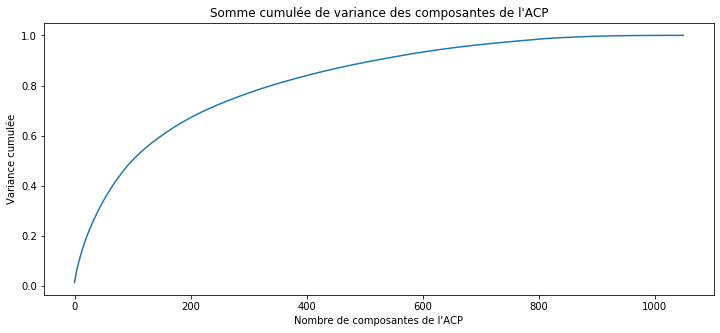

In [115]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(list(range(X.shape[0])),
         np.cumsum(pca.explained_variance_ratio_))


In [116]:
sum_pca = np.cumsum(pca.explained_variance_ratio_)
for counter, value in enumerate(sum_pca):
    if value > 0.80:
        X_reduce = pca.transform(X)[:,:counter]
        break
    

In [117]:
print('nombre de features : {}, variance : {}'.format(counter+1,np.cumsum(pca.explained_variance_ratio_)[counter]))

nombre de features : 341, variance : 0.8006493269459486


In [118]:
X_reduce.shape

(1050, 340)

In [119]:
X_reduce.shape

(1050, 340)

**Export**

In [121]:
np.save('data_saved/X_reduce_NLP.csv', X_reduce)

**Données finales**

In [79]:
from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
import time
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [80]:


dict_kmeans_nlp = {}

inertia_nlp = {}

max_clusters_nlp=100


f = IntProgress(min=1, max=max_clusters_nlp) # instantiate the bar
chaine = str(1)+'/'+str(max_clusters_nlp)
g = Text(value=chaine)
display(f) # display the bar
display(g)

for k in range(1,max_clusters_nlp):
    kmeans_nlp = KMeans(n_clusters=k,
                   verbose=1,
                   random_state=0,
                   n_jobs=-1).fit(X_reduce)
    inertia_nlp[k] = kmeans_nlp.inertia_
    dict_kmeans_nlp[k] = kmeans_nlp
    f.value = k # signal to increment the progress bar
    g.value =str(k)+'/'+str(max_clusters_nlp)

IntProgress(value=1, min=1)

Text(value='1/100')

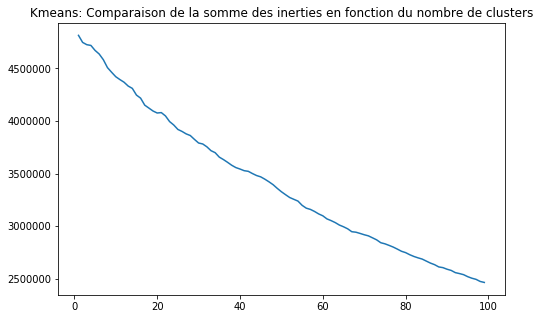

In [81]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
sns.lineplot(list(inertia_nlp.keys()),
             list(inertia_nlp.values())
            )

In [82]:
from sklearn.metrics import silhouette_score

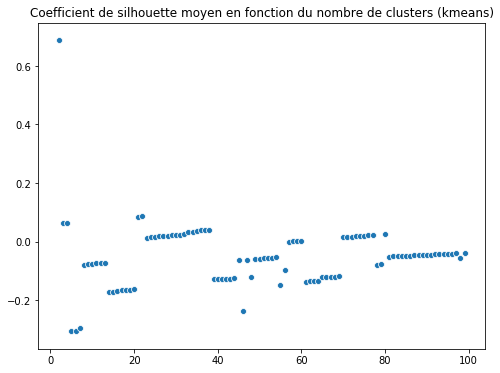

In [83]:

silhouettes_kmeans_nlp = {}
for i in range(2,max_clusters_nlp):
    silhouettes_kmeans_nlp[i] = silhouette_score(X = X_reduce,
                                             labels= list(dict_kmeans_nlp[i].labels_))

plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(silhouettes_kmeans_nlp.keys()),
               y = list(silhouettes_kmeans_nlp.values()))
plt.show()



In [84]:
for key, value in silhouettes_kmeans_nlp.items():
    if value == max(silhouettes_kmeans_nlp.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters_optimal = key

le coefficient de silhouette est maximal pour 2 clusters (score = 0.6871779774677732)


In [85]:
if nb_clusters_optimal < 5:
    nb_clusters_optimal = 10

In [86]:
dict_kmeans_nlp[nb_clusters_optimal]

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=1)

In [87]:
train_nlp = pd.concat([train, test]).copy()
train_nlp['label_kmeans'] = dict_kmeans_nlp[nb_clusters_optimal].labels_

Comparaison des clusters par rapport aux catégories présentes dans le jeu de données de base

In [88]:
groups_cat_kmeans_nlp = train_nlp[['cat_lvl_2', 'label_kmeans']].groupby('label_kmeans')
val_presence = []
for i in range(1,nb_clusters_optimal):
    val_presence.append(groups_cat_kmeans_nlp.get_group(i).groupby('cat_lvl_2').count().sort_values(by='label_kmeans', ascending=False).iloc[0].tolist()[0]/groups_cat_kmeans_nlp.get_group(i).groupby('cat_lvl_2').count().sum().values.tolist()[0]*100)

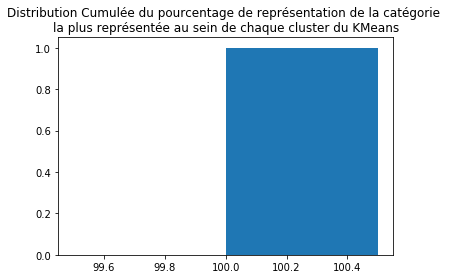

In [89]:
plt.title('Distribution Cumulée du pourcentage de représentation de la catégorie \nla plus représentée au sein de chaque cluster du KMeans')
plt.hist(val_presence,cumulative=True, density=True, bins=nb_clusters_optimal)
plt.show()

Pour la majorité des clusters (95%), la catégorie la plus représentée représente moins de 20 % des individus de l'échantillon. Notre classifieur n'a pas identifié les mêmes catégories que celles présentées dans le jeu de données initial.

# Données visuelles

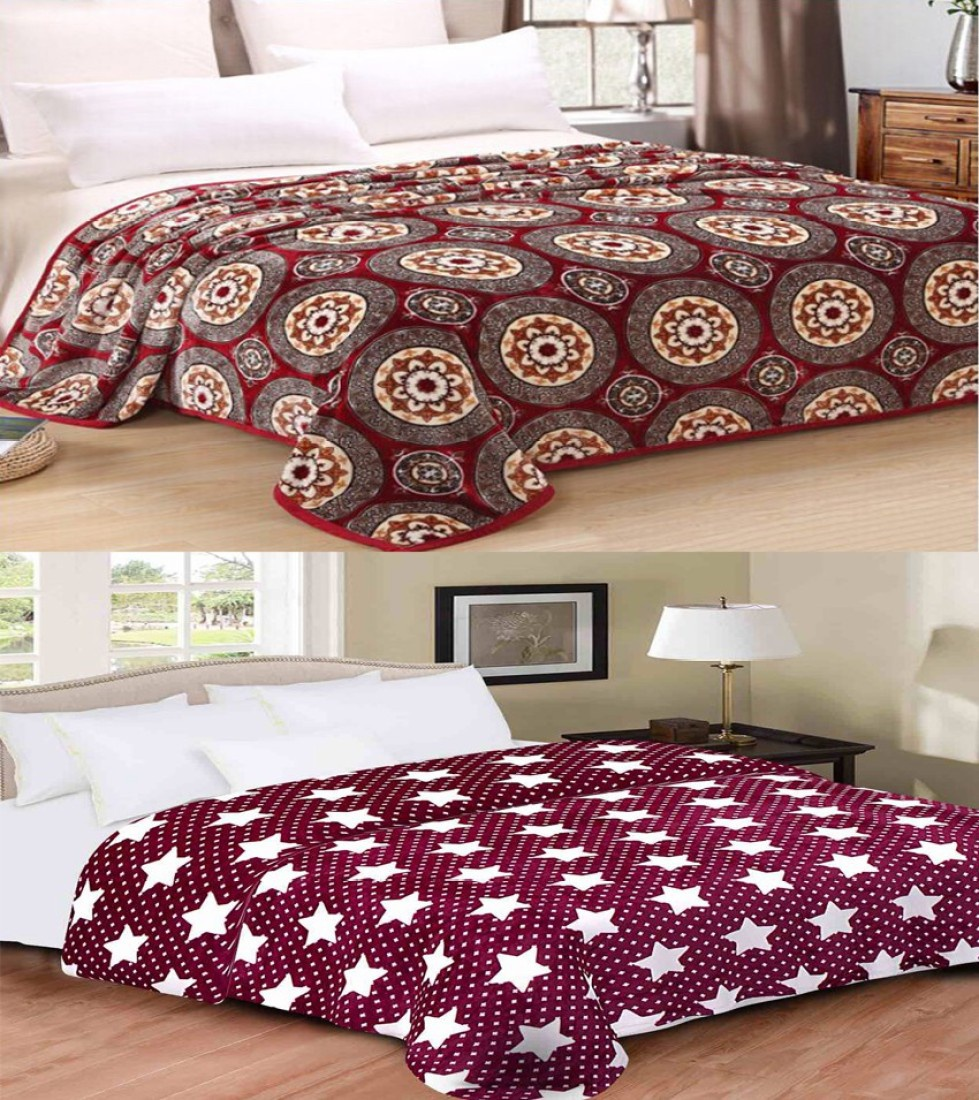

In [17]:
from IPython.display import Image
Image('data/Images/'+ str(data.sample(1)['image'].values.tolist()[0]), width=100 )

Ensuite, vous analyserez le jeu de données déjà constitué en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !


In [18]:
#Echantillon de données
img_echantillon = data.sample(50, random_state=10)

In [19]:
img_echantillon['image'] = img_echantillon['image'].apply(lambda x: 'data/Images/'+str(x))

In [20]:
img_echantillon['image'].head(1)

775    data/Images/93618b8a998782d4d847ee5cba5c7de2.jpg
Name: image, dtype: object

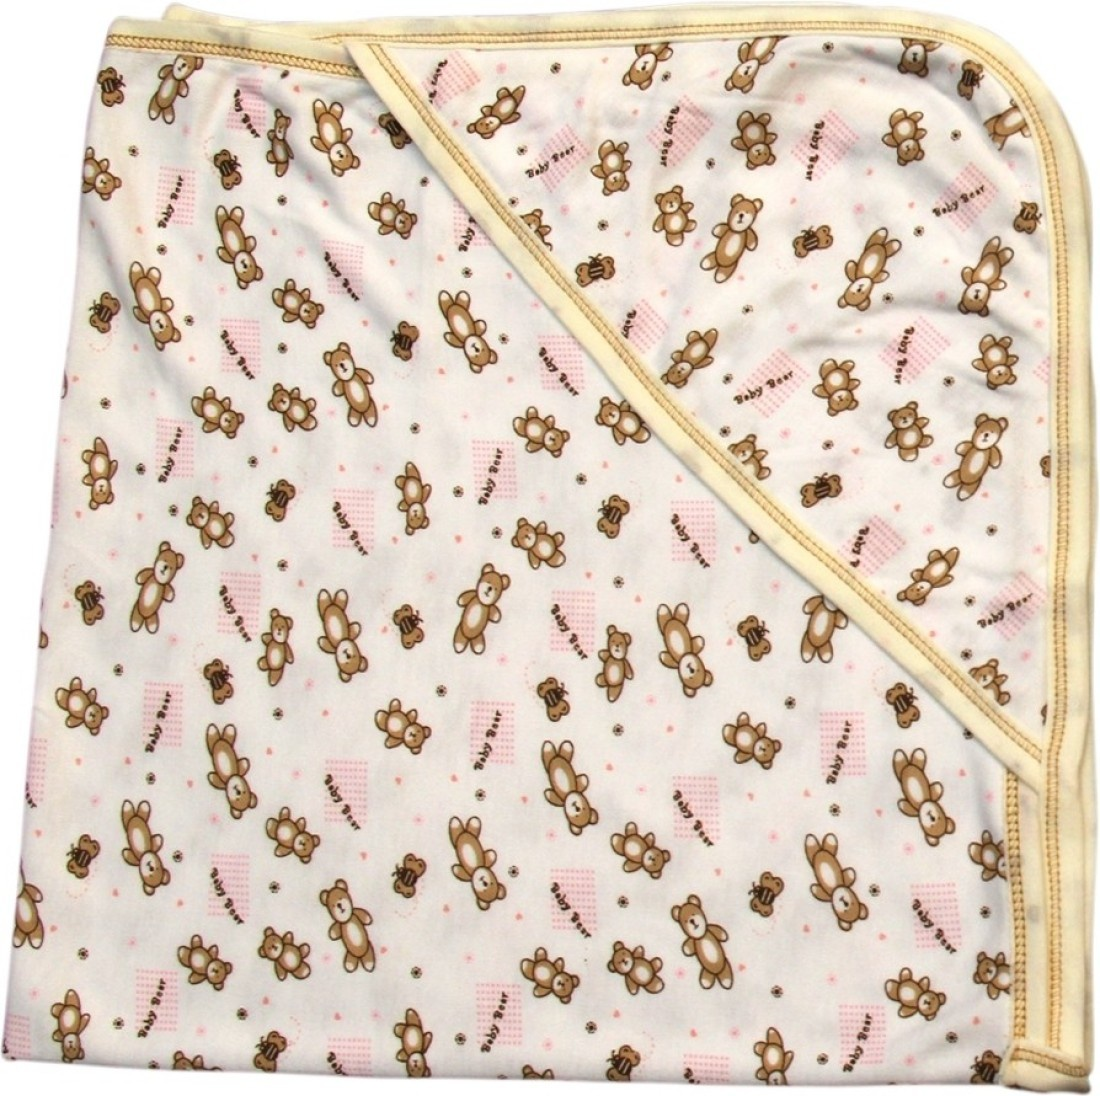

In [21]:
Image(img_echantillon.iloc[12]['image'], width=150)

In [22]:
img_echantillon.iloc[12]

uniq_id                                     8818424349b75a67775353d1feef2635
crawl_timestamp                                    2015-12-12 11:46:53 +0000
product_url                http://www.flipkart.com/offspring-printed-sing...
product_name                     Offspring Printed Single Wrapper Multicolor
pid                                                         BLAE8BUKXGJ3DHMG
retail_price                                                             375
discounted_price                                                         290
image                       data/Images/8818424349b75a67775353d1feef2635.jpg
is_FK_Advantage_product                                                False
description                Buy Offspring Printed Single Wrapper Multicolo...
product_rating                                           No rating available
overall_rating                                           No rating available
brand                                                              Offspring

## Préambule : essai de convolution

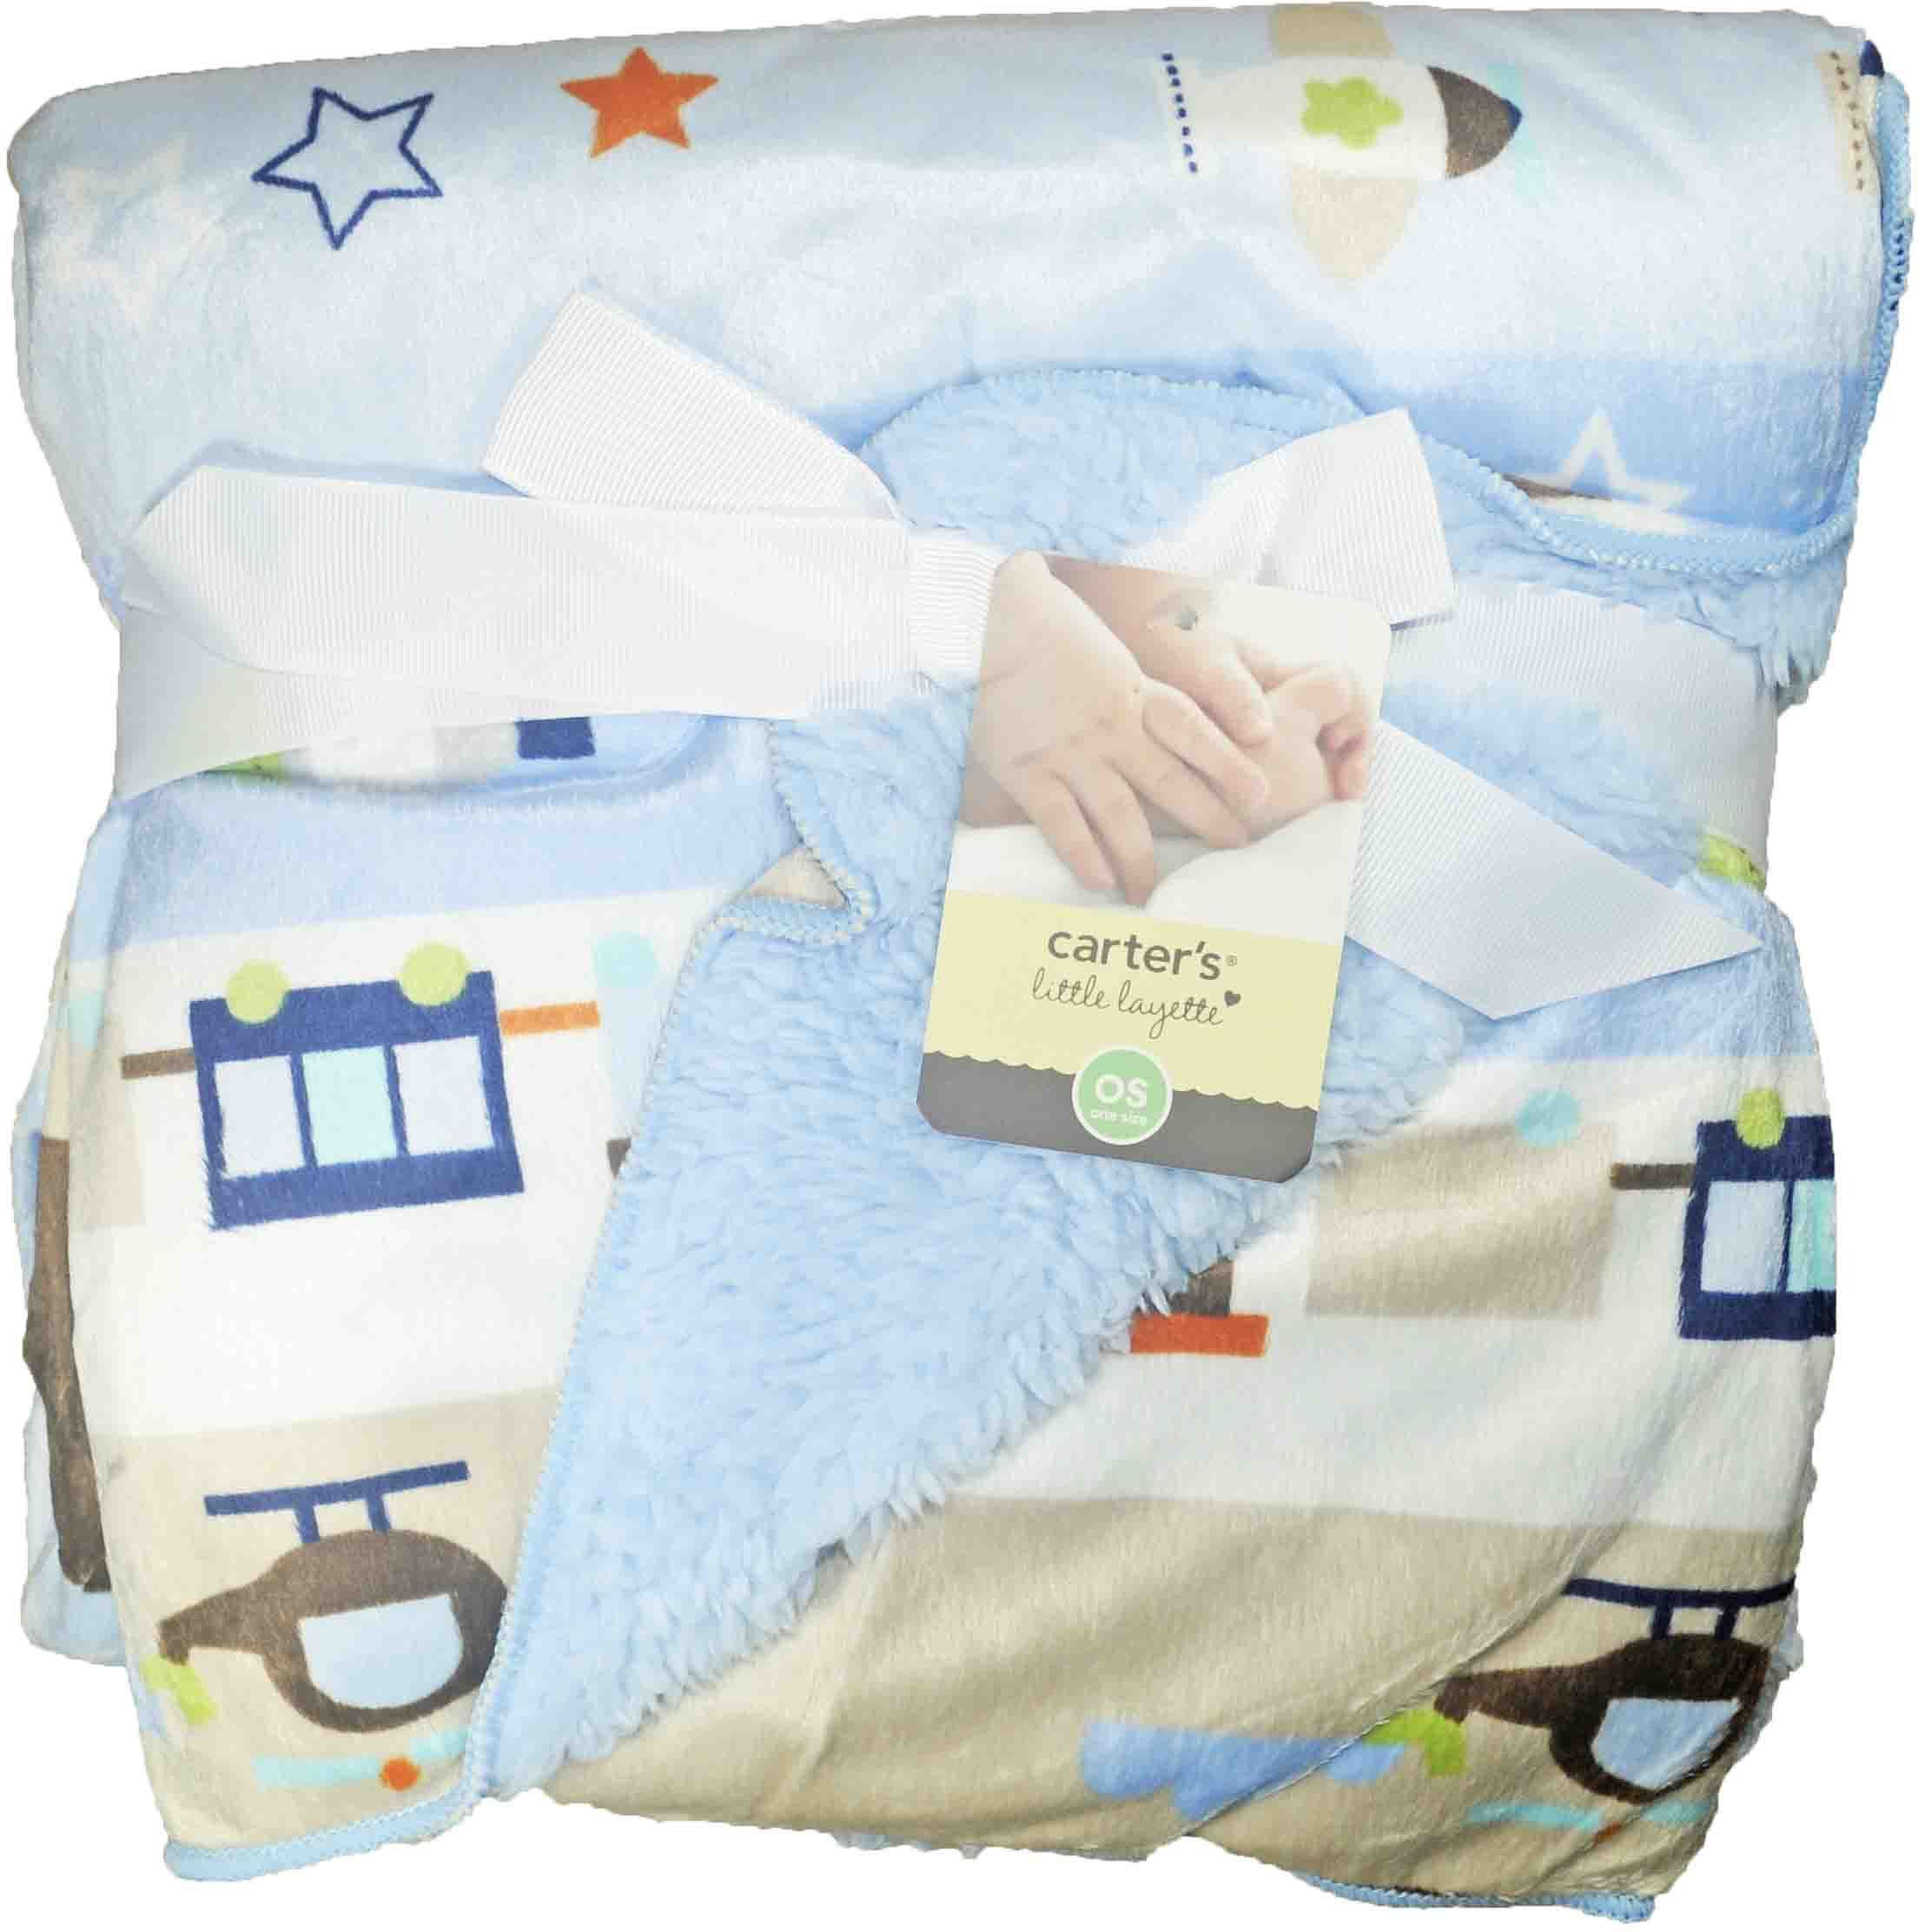

In [96]:
Image('data/Images/93618b8a998782d4d847ee5cba5c7de2.jpg', width=200)

In [97]:
img_conv = Image_PIL.open('data/Images/93618b8a998782d4d847ee5cba5c7de2.jpg')

In [98]:
img_conv = np.array(img_conv)

In [99]:
img_conv = cv2.resize(img_conv, (200,200))

In [100]:
def filtre_moyenneur(img, voisinage = 1):
    '''Remplace chaque pixel par l\'intensité moyenne de son voisinage'''
    etendue = 1+2*voisinage
    img2 = np.copy(img)
    
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if (i<voisinage)|(i>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            if (j<voisinage)|(j>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            
            
    for i in range(voisinage,img.shape[0]-voisinage):
        for j in range(voisinage,img.shape[1]-voisinage):
            mean = 0
            for mean_x in range(i-voisinage, i+voisinage+1):
                for mean_y in range(j-voisinage, j+voisinage+1):
                    mean += img[mean_x, mean_y]
            img2[i,j] = mean/(etendue**2)
    
    
    return img2  

In [101]:
img_conv_traitee_1 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=1)
img_conv_traitee_2 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=2)
img_conv_traitee_3 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=3)
img_conv_traitee_4 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=4)


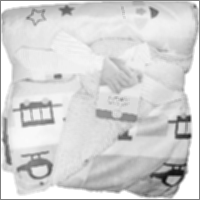

In [102]:
Image_PIL.fromarray(img_conv_traitee_1)

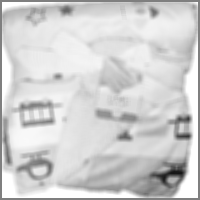

In [103]:
Image_PIL.fromarray(img_conv_traitee_2)

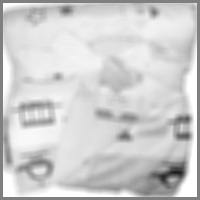

In [104]:
Image_PIL.fromarray(img_conv_traitee_3)

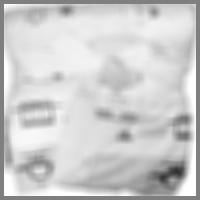

In [105]:
Image_PIL.fromarray(img_conv_traitee_4)

## Prétraitement

### Essais

**Réduction de bruit**

In [106]:
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

In [107]:
im = np.array(Image_PIL.open(img_echantillon.iloc[12]['image']))

In [108]:
im = gaussian_filter(im, sigma=3)

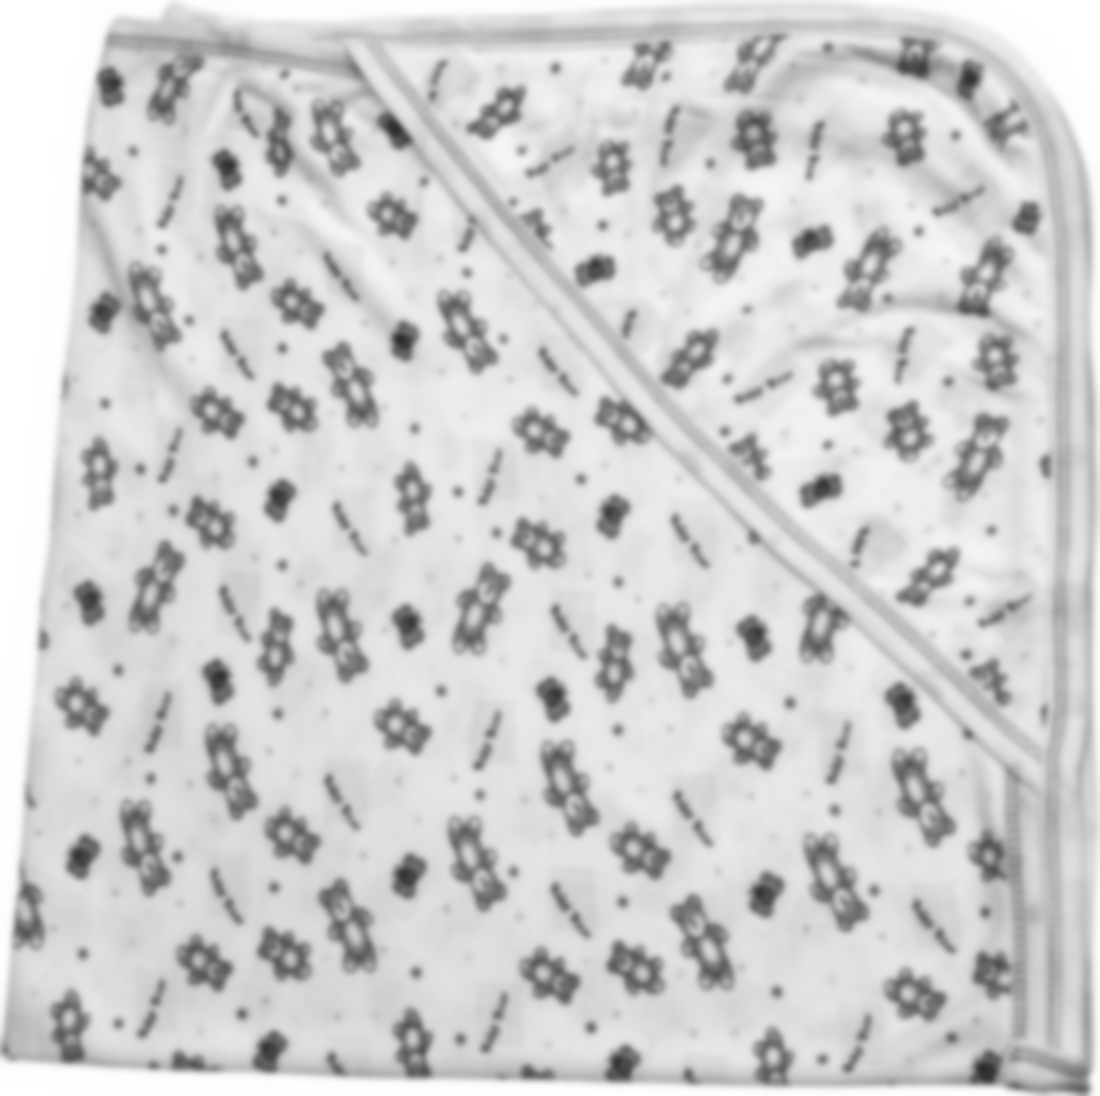

In [109]:
Image_PIL.fromarray(im)

**Egalisation**

In [110]:
hist, bins = np.histogram(im.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

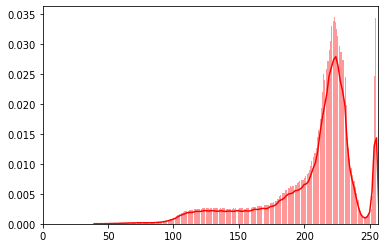

In [111]:
plt.figure(figsize=(6,4))
sns.distplot(im.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

In [112]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [113]:
im2=cdf[im]

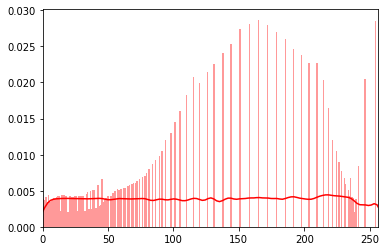

In [114]:
plt.figure(figsize=(6,4))
sns.distplot(im2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

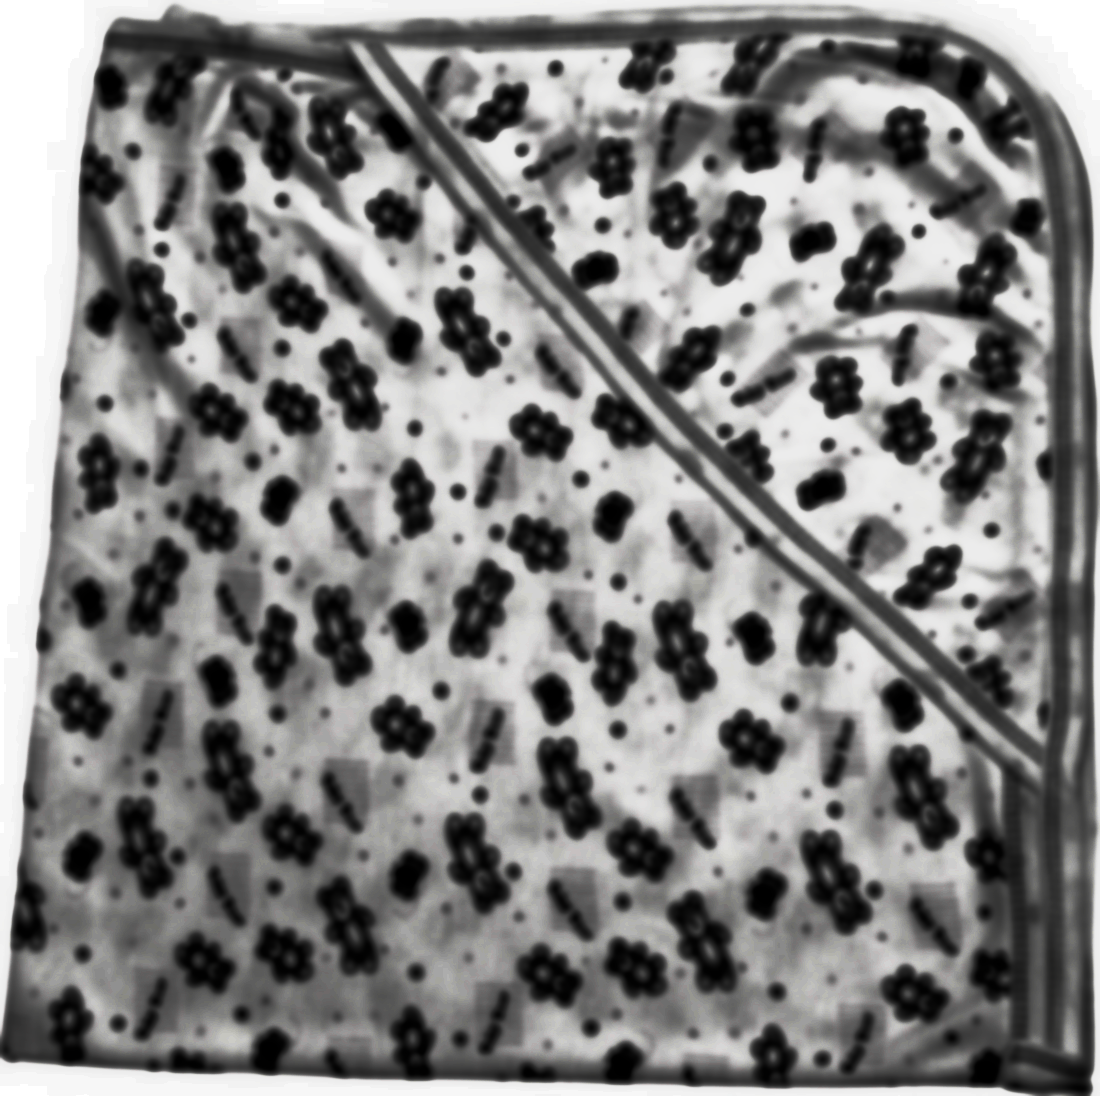

In [115]:
Image_PIL.fromarray(im2)

In [116]:
img3 = cv2.imread(img_echantillon.iloc[12]['image'],0)
equ = cv2.equalizeHist(img3)
res = np.hstack((img3,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)

True

In [117]:
img3.shape

(1096, 1100)

**Redimensionnement**

Taille d'origine des images

In [118]:
min_x = 100000
max_x = 0
min_y = 100000
max_y = 0
for image in img_echantillon['image'].tolist():
    shape = np.array(Image_PIL.open(image)).shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]

In [119]:
print('min_x {},\nmax_x {},\nmin_y {},\nmax_y {}'.format(min_x, max_x, min_y, max_y))

min_x 286,
max_x 4098,
min_y 302,
max_y 2800


Redimensionnement

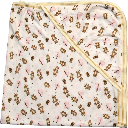

In [120]:
resize_img = cv2.resize(np.array(Image_PIL.open(img_echantillon.iloc[12]['image'])), dsize=(128,128))
Image_PIL.fromarray(resize_img)

### Fonction de prétraitement Complète

In [25]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    del shape
    return im

In [24]:
def preprocess(image, path=False):
    '''prétraitement des images:
    * filtre gaussian
    * égalisation de l'histogramme
    * redimensionnement
    prend un entrée le chemin vers l'image et en sortie la matrice np.array de l'image traitée
    '''
    #ouverture du fichier
    if path == False: #si on a fourni un array en entree :
        im = image
    else: #si on a fourni un chemin vers le fichier en entree:
        im = np.array(Image_PIL.open(image))
    
    #greyscale
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #flou gaussien
    im = gaussian_filter(im, sigma=2)
    
    #égalisation
    im = cv2.equalizeHist(im)
    
    return redim(im, 128, 128)

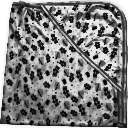

In [123]:
Image_PIL.fromarray(preprocess(img_echantillon.iloc[12]['image'], path=True))

## Extraction des caractéristiques (SIFT/ORB/SURF)

### Essais

**SIFT**

Ressources : https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

In [26]:
i = np.random.randint(img_echantillon.shape[0]-1)
img_sift = preprocess(img_echantillon.iloc[12]['image'], path=True)

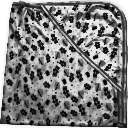

In [27]:
Image_PIL.fromarray(img_sift)

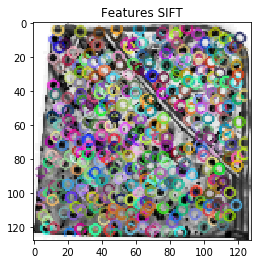

In [28]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(img_sift,None)
img=cv2.drawKeypoints(img_sift,kp,img_sift)

plt.figure(figsize=(4,4))
plt.title('Features SIFT')
plt.imshow(img)

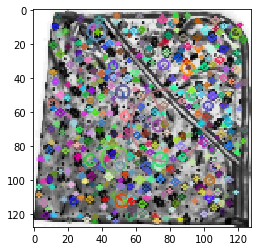

In [31]:
img=cv2.drawKeypoints(img_sift,kp,img_sift,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(4,4))
plt.imshow(img)

**ORB**

In [128]:
img_orb = preprocess(img_echantillon.iloc[i]['image'], path=True)

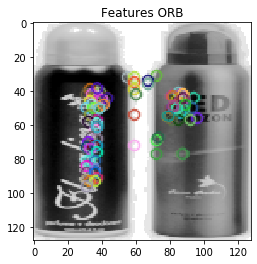

In [129]:
orb = cv2.ORB_create()

#find keypoints and descriptors
kp, des = orb.detectAndCompute(img_orb, mask = None)
#draw only keypoints location, not size and orientation:
image_orb = cv2.drawKeypoints(img_orb, kp, outImage = True, flags=2)
plt.title('Features ORB')
plt.imshow(image_orb)
plt.show()

In [130]:
len(kp)

84

In [131]:
des.shape

(84, 32)

**SURF**

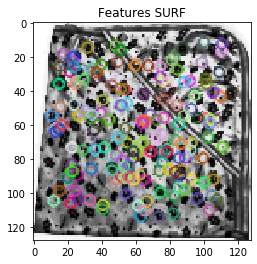

In [33]:
img_surf = preprocess(img_echantillon.iloc[12]['image'], path=True)
surf = cv2.xfeatures2d.SURF_create()
kp = surf.detect(img_surf,None)
image_surf = cv2.drawKeypoints(img_surf, kp, outImage = True, flags=2)
plt.figure(figsize=(4,4))
plt.title('Features SURF')
plt.imshow(image_surf)

In [133]:
kp_surf, des_surf = sift.detectAndCompute(img_surf,None)

In [134]:
des_surf[2].shape

(128,)

In [135]:
des_surf[0].shape

(128,)

### Fonctions

In [136]:
def get_files(path_list):
    '''Renvoie la liste des matrices d\'images à partir d'une liste de chemins'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2.imread(image_path, 0)
        im = np.array(Image_PIL.open(image_path))
        liste_image.append(im)
        compteur +=1
    return liste_image

In [137]:
def create_features():
    '''Initialise un algorithme SURF'''
    return cv2.xfeatures2d.SURF_create()
    

def features(surf, image):
    '''renvoie les keypoints et descripteurs d\'une image à partir du détecteur surf'''
    keypoints, descriptors = surf.detectAndCompute(image, None)
    return [keypoints, descriptors]

def pipeline_feature(image):
    '''traitement complet d\'une image : 
    * initialise l\'algorithme, 
    *prétraite l'image, 
    *recherche les features
    *retourne les features'''
    
    surf = create_features()
    image = preprocess(image, path=False)
    #gr = grey(image)
    keypoints, descriptors = features(surf, image)
    return keypoints, descriptors

In [138]:
image_essai = get_files(img_echantillon['image'])[1]

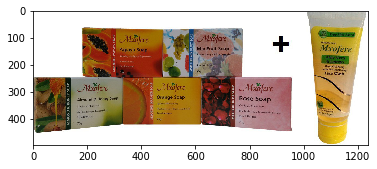

In [139]:
plt.imshow(image_essai)

In [140]:

j=0

echantillon = get_files(img_echantillon['image'].tolist())
max_count = len(echantillon)
f = IntProgress(min=0, max=max_count) # instantiate the bar
chaine = str(0)+'/'+str(max_count)
g = Text(value=chaine)
display(f) # display the bar
display(g)
liste_keypoints = []
liste_descripteurs = []


for array_image in echantillon:
    j+=1
    kea, des = pipeline_feature(array_image)
    liste_keypoints.append(kea)
    liste_descripteurs.append(des)
    f.value = j # signal to increment the progress bar
    g.value =str(j)+'/'+str(max_count)

IntProgress(value=0, max=50)

Text(value='0/50')

In [141]:
liste_descripteurs[0].shape

(134, 64)

In [142]:
liste_descripteurs[0].reshape(1,-1)

array([[-0.00094612, -0.00405627,  0.00392699, ..., -0.01303167,
         0.01267168,  0.01343737]], dtype=float32)

In [143]:
print('Nombre de liste de keypoints : ', len(liste_keypoints))
print('Nombre de keypoints pour l\'élément 0 : ', len(liste_keypoints[0]))
print('Nombre de keypoints pour l\'élément 2 : ', len(liste_keypoints[2]))

Nombre de liste de keypoints :  50
Nombre de keypoints pour l'élément 0 :  134
Nombre de keypoints pour l'élément 2 :  95


In [144]:
print('Dimension descripteurs élément 0 : ', liste_descripteurs[0].shape)
print('Dimension descripteurs élément 1 : ', liste_descripteurs[1].shape)

Dimension descripteurs élément 0 :  (134, 64)
Dimension descripteurs élément 1 :  (105, 64)


In [145]:
for el, ech in zip(liste_descripteurs, echantillon):
    print(el.shape, ' - ', ech.shape)

(134, 64)  -  (2224, 2208, 3)
(105, 64)  -  (496, 1238, 3)
(95, 64)  -  (1100, 1000, 3)
(106, 64)  -  (1100, 612, 3)
(101, 64)  -  (1360, 472, 3)
(107, 64)  -  (1488, 2800, 3)
(81, 64)  -  (1211, 739, 3)
(184, 64)  -  (4098, 1514, 3)
(58, 64)  -  (773, 756, 3)
(100, 64)  -  (1200, 900, 3)
(122, 64)  -  (1950, 1938, 3)
(126, 64)  -  (1100, 409, 3)
(167, 64)  -  (1096, 1100, 3)
(103, 64)  -  (1000, 668, 3)
(134, 64)  -  (921, 1100, 3)
(185, 64)  -  (1100, 1074, 3)
(133, 64)  -  (2000, 1640, 3)
(98, 64)  -  (1223, 1067, 3)
(67, 64)  -  (993, 1100, 3)
(158, 64)  -  (3558, 2356, 3)
(75, 64)  -  (995, 417, 3)
(109, 64)  -  (1100, 1031, 3)
(100, 64)  -  (1000, 880, 3)
(101, 64)  -  (1440, 1068, 3)
(154, 64)  -  (890, 592, 3)
(118, 64)  -  (995, 850, 3)
(106, 64)  -  (1312, 852, 3)
(43, 64)  -  (286, 416, 3)
(129, 64)  -  (1100, 815, 3)
(97, 64)  -  (1100, 1000, 3)
(136, 64)  -  (1100, 1068, 3)
(98, 64)  -  (1000, 302, 3)
(121, 64)  -  (2012, 1296, 3)
(124, 64)  -  (844, 1100, 3)
(156, 64)  - 

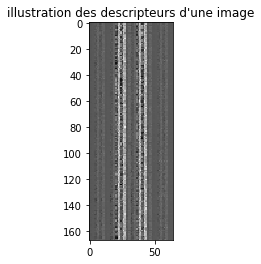

In [146]:
plt.title('illustration des descripteurs d\'une image')
plt.imshow(liste_descripteurs[12], cmap='gray')

NameError: name 'liste_descripteurs' is not defined

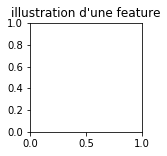

In [35]:
plt.figure(figsize=(2,2))
plt.title('illustration d\'une feature')
plt.imshow(liste_descripteurs[0][12].reshape(8,8))

In [148]:
def extraction_features(data_visu):
    '''Extraction des features à partir des données'''
    
    #chargement des images
    data_visu['image'] = data_visu['image'].apply(lambda x: 'data/Images/'+str(x))
    liste_images = get_files(data_visu['image'].tolist())
    max_count = len(liste_images)
    
    #affichage du compteur
    f = IntProgress(min=0, max=max_count) # instantiate the bar
    chaine = str(0)+'/'+str(max_count)
    g = Text(value=chaine)
    display(f) # display the bar
    display(g)
    liste_features = []
    liste_descripteurs = []
    liste_descripteurs_formates = []

    #boucle d'extraction des features de chaque image
    j=0
    for array_image in liste_images:
        j+=1
        fea, des = pipeline_feature(array_image)
        
        
        liste_features.append(fea)
        liste_descripteurs.append(des)
        f.value = j # signal to increment the progress bar
        g.value = str(j)+'/'+str(max_count)
    
    #harmonisation du nombre de features par image : détermination dimension maximum
    nb_features_max = 0
    for descripteur in liste_descripteurs:
        if descripteur.shape[0] > nb_features_max:
            nb_features_max = descripteur.shape[0]
    #on transforme les array des descripteurs en vecteurs (PM : un descripteur = 64 pixels de large)
    liste_descripteurs_flatten = []
    for descripteur in liste_descripteurs:
        liste_descripteurs_flatten.append(descripteur.reshape(1,-1))   
    
    #harmonisation du nombre de features par image : ajout pixels noirs
    k = 0
    for descripteur in liste_descripteurs_flatten:
        if descripteur.shape[0] <= nb_features_max*64:
            liste_descripteurs_formates.append(
                np.hstack([descripteur.reshape(1,-1), 
                           np.zeros(nb_features_max*64 - descripteur.shape[1]).reshape(1,-1)])
            )        
        else:
            liste_descripteurs_formates.append(descripteur)
            
    #assemblage_features
    array_descripteurs = np.vstack(liste_descripteurs_formates)
    
    del liste_descripteurs_formates, descripteur, liste_images, max_count
    
    
    return liste_features, liste_descripteurs, array_descripteurs

In [149]:
data_visuelle = pd.concat([train, test]).copy()
#data_visuelle = data.sample(100, random_state=42)

features_total, descripteurs_total, descripteurs_array = extraction_features(data_visuelle)

D:\Programs\envs\openclassrooms\lib\site-packages\PIL\Image.py:2731: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


IntProgress(value=0, max=1050)

Text(value='0/1050')

In [150]:
descripteurs_array.shape

(1050, 34816)

In [151]:
descripteurs_array[0,:]

array([-0.00013082, -0.0027829 ,  0.0002598 , ...,  0.        ,
        0.        ,  0.        ])

(1050, 34816)


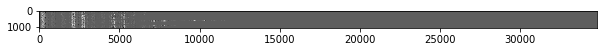

In [152]:
print(descripteurs_array.shape)
plt.figure(figsize=(10,10))
plt.imshow(descripteurs_array, cmap='gray')

export des descripteurs

### Création de nouvelles features à partir des descripteurs

In [153]:
descripteurs_total[0].shape

(96, 64)

In [154]:
np.var(descripteurs_total[0])

0.013280683

In [155]:
from scipy.stats import moment

liste_min = [np.min(descripteur) for descripteur in descripteurs_total]
liste_max = [np.max(descripteur) for descripteur in descripteurs_total]
liste_mean = [np.mean(descripteur) for descripteur in descripteurs_total]
liste_var = [np.var(descripteur) for descripteur in descripteurs_total]
liste_order_3 = [np.mean(moment(descripteur, moment = 3, axis=1)) for descripteur in descripteurs_total]
liste_order_4 = [np.mean(moment(descripteur, moment = 4, axis=1)) for descripteur in descripteurs_total]

In [156]:
array_features_descripteurs = np.vstack([liste_min, liste_max, liste_mean, liste_var, liste_order_3, liste_order_4])

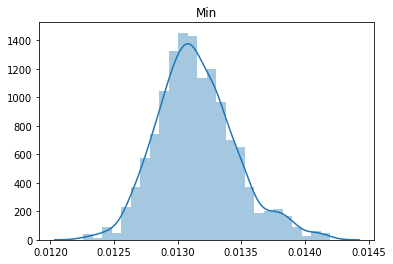

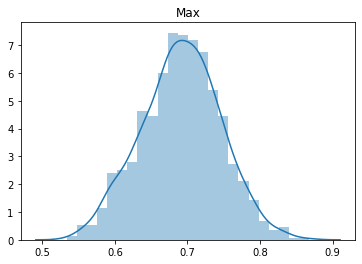

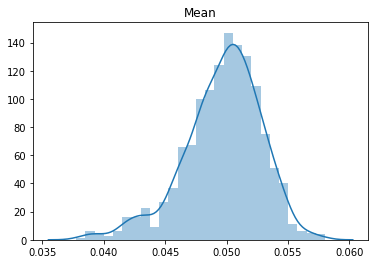

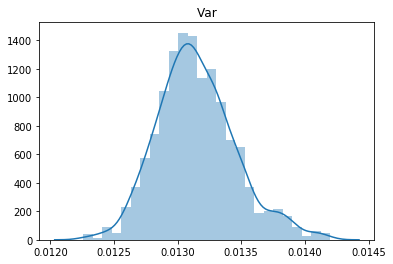

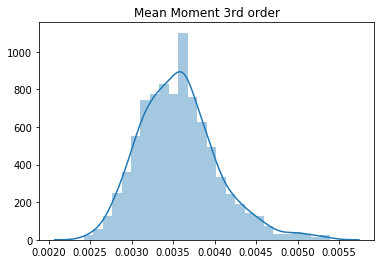

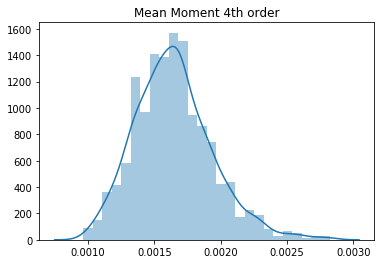

In [157]:
%matplotlib inline

plt.figure()
plt.title('Min')
sns.distplot(liste_var)

plt.figure()
plt.title('Max')
sns.distplot(liste_max)

plt.figure()
plt.title('Mean')
sns.distplot(liste_mean)

plt.figure()
plt.title('Var')
sns.distplot(liste_var)

plt.figure()
plt.title('Mean Moment 3rd order')
sns.distplot(liste_order_3)

plt.figure()
plt.title('Mean Moment 4th order')
sns.distplot(liste_order_4)

### Export

In [158]:
np.save('data_saved/array_descripteurs.csv', descripteurs_array)
np.save('data_saved/array_features_descripteurs', array_features_descripteurs)

## Classifieur non supervisé

### ACP

In [159]:
pca_descripteurs = PCA()
features_ss = StandardScaler()
pca_descripteurs.fit(features_ss.fit_transform(np.transpose(descripteurs_array.T)))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [160]:
pca_descripteurs.n_components_

1050

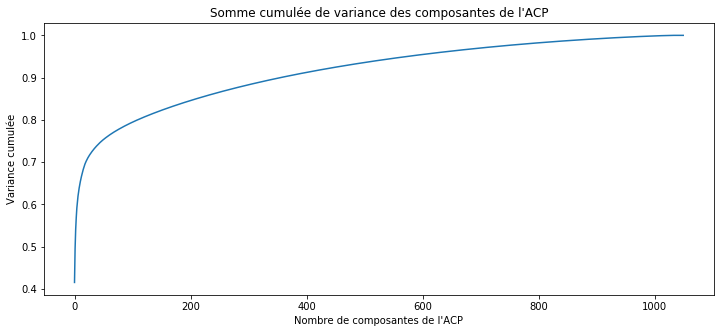

In [161]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(list(range(descripteurs_array.shape[0])),
         np.cumsum(pca_descripteurs.explained_variance_ratio_))

In [162]:
np.cumsum(pca_descripteurs.explained_variance_ratio_)[650]

0.9628642118510141

95 % de la variance totale avec 650 features

In [163]:
array_descripteurs_reduit = pca_descripteurs.transform(descripteurs_array[:650,:])

In [164]:
array_descripteurs_reduit.shape

(650, 1050)

In [165]:
np.save('data_saved/array_descripteurs_reduit.csv', array_descripteurs_reduit)

### Classification

In [166]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

#### Kmeans

In [167]:
dict_kmeans = {}
inertia = {}
max_clusters=80

f = IntProgress(min=0, max=max_clusters) # instantiate the bar
chaine = str(0)+'/'+str(max_count)
g = Text(value=chaine)
display(f) # display the bar
display(g)

for k in range(1,max_clusters+1):
    kmeans = KMeans(n_clusters=k,
                   verbose=1,
                   random_state=0,
                   n_jobs=-1).fit(array_descripteurs_reduit)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans
    f.value = k # signal to increment the progress bar
    g.value =str(k+1)+'/'+str(max_clusters)

IntProgress(value=0, max=80)

Text(value='0/50')

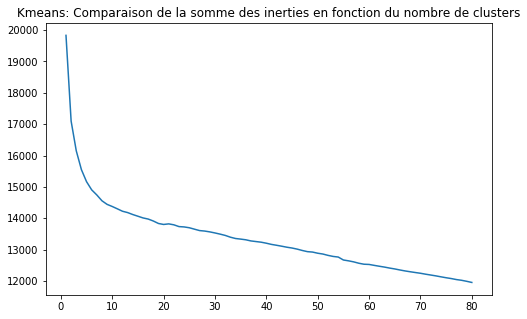

In [168]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
sns.lineplot(list(inertia.keys()),
             list(inertia.values())
            )

In [169]:
from sklearn.metrics import silhouette_score

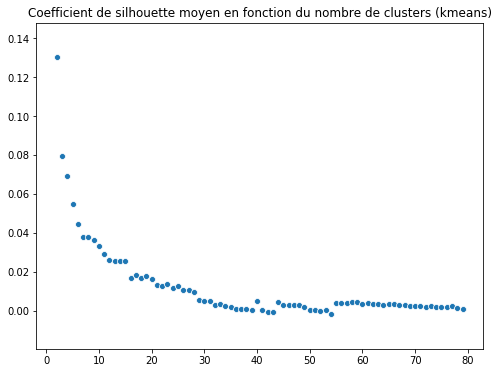

In [170]:

silhouettes_kmeans = {}
for i in range(2,max_clusters):
    silhouettes_kmeans[i] = silhouette_score(X = array_descripteurs_reduit,
                                             labels= list(dict_kmeans[i].labels_))

plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(silhouettes_kmeans.keys()),
               y = list(silhouettes_kmeans.values()))
plt.show()



In [171]:
for key, value in silhouettes_kmeans.items():
    if value == max(silhouettes_kmeans.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters = key

le coefficient de silhouette est maximal pour 2 clusters (score = 0.13023934029860768)


#### Visualisation des visual words

Exemple en prenant une séparation avec clusters

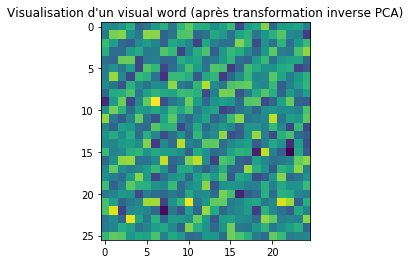

In [172]:
plt.title('Visualisation d\'un visual word (après transformation inverse PCA)')

plt.imshow(np.dot(dict_kmeans[25].cluster_centers_[4], pca_descripteurs.components_[:, :650]).reshape(26,25))

#### Histogrammes

## CNN Données visuelles

### Report fonctions

In [173]:
def get_files(path_list):
    '''Renvoie la liste des matrices d\'images à partir d'une liste de chemins'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2.imread(image_path, 0)
        im = np.array(Image_PIL.open(image_path))
        liste_image.append(im)
        compteur +=1
    
    del compteur
    del im
    
    return liste_image

In [174]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    
    del shape
    
    return im

### Données

In [175]:
train['image'] = train['image'].apply(lambda x: 'data/Images/'+str(x))
test['image'] = test['image'].apply(lambda x: 'data/Images/'+str(x))

D:\Programs\envs\openclassrooms\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programs\envs\openclassrooms\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [176]:
train_cnn = get_files(train.copy()['image'].tolist())
test_cnn = get_files(test.copy()['image'].tolist())

D:\Programs\envs\openclassrooms\lib\site-packages\PIL\Image.py:2731: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [177]:
len(train_cnn)

787

In [178]:
len(test_cnn)

263

In [179]:
redim(train_cnn[0], 128, 128).shape

(128, 128, 3)

In [180]:
redim(train_cnn[0], 128, 128).reshape(1,-1,3).shape

(1, 16384, 3)

In [181]:
train_array_cnn = np.vstack([redim(img, 128, 128).reshape(1,128,128,3) for img in train_cnn])
test_array_cnn = np.vstack([redim(img, 128, 128).reshape(1,128,128,3) for img in test_cnn])

In [182]:
train_array_cnn.shape

(787, 128, 128, 3)

In [183]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
array_cats = ohe.fit_transform(np.array(train['cat_lvl_2']).reshape(-1,1))

In [184]:
array_cats.todense().shape

(787, 57)

In [185]:
array_cats.shape

(787, 57)

In [186]:
train_array_cats = ohe.transform(train[['cat_lvl_2']]).todense()
test_array_cats = ohe.transform(test[['cat_lvl_2']]).todense()

In [187]:
ohe.categories_

[array(['Baby & Kids Gifts', 'Baby Bath & Skin', 'Baby Bedding',
        'Baby Grooming', 'Bar & Glassware', 'Bath Linen', 'Bath and Spa',
        'Bed Linen', 'Body and Skin Care', 'Candles & Fragrances',
        'Clocks', 'Coffee Mugs', 'Combos and Kits', 'Computer Components',
        'Computer Peripherals', 'Containers & Bottles', 'Cookware',
        'Curtains & Accessories', 'Cushions, Pillows & Covers',
        'Decorative Lighting & Lamps', 'Diapering & Potty Training',
        'Dinnerware & Crockery', 'Eye Care', 'Feeding & Nursing',
        'Floor Coverings', 'Flowers, Plants & Vases', 'Fragrances',
        'Furniture & Furnishings', 'Garden & Leisure', 'Hair Care',
        'Health Care', 'Housekeeping & Laundry', 'Infant Wear',
        'Kitchen & Dining Linen', 'Kitchen Tools',
        "Kripa's Home Furnishing", 'Laptop Accessories', 'Laptops',
        'Lighting', 'Living', 'Living Room Furnishing', 'Makeup',
        'Network Components', 'Pressure Cookers & Pans',
        'R

### Construction Réseau

In [188]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation

In [189]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128,128,3,)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(ohe.categories_[0].shape[0], activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='sgd')

In [190]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 57)                1867833   
Total params: 1,877,977
Trainable params: 1,877,977
Non-trainable params: 0
_________________________________________________________________


### Entraînement

In [191]:
train_array_cnn.shape

(787, 128, 128, 3)

In [192]:
model_info = model.fit(train_array_cnn, train_array_cats, epochs=3, batch_size=40, verbose=2)



Epoch 1/3
 - 12s - loss: 0.0324
Epoch 2/3
 - 8s - loss: 0.0323
Epoch 3/3
 - 9s - loss: 0.0323


In [193]:
for couche in model.get_weights():
    print(couche.shape)

(3, 3, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(32768, 57)
(57,)


In [194]:
predictions_test = model.predict(test_array_cnn)

In [195]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(predictions_test, axis=1).reshape(-1,1), 
               np.argmax(test_array_cats, axis=1).reshape(-1,1))

0.08365019011406843

In [196]:
np.argmax(test_array_cats, axis=1).reshape(1,-1)

matrix([[42, 38, 36, 26, 56, 32, 46, 14,  7,  7, 56,  1, 11,  6, 51, 36,
         32, 36,  5, 17, 16, 36, 32, 36, 56, 12, 19,  0, 26, 11, 11, 42,
         36, 56, 50,  7, 56, 46, 46, 42, 18, 41, 38, 17, 41, 34, 16, 48,
          0,  7, 11, 46, 15, 39, 42, 32, 29, 34, 51, 39,  5,  0, 56, 16,
         56,  5,  0, 19,  7, 56, 32, 36, 42, 36, 56, 42,  7, 46, 36,  7,
         33,  5, 42, 34, 42, 56, 24, 19, 46, 50, 40,  7, 11, 46, 56, 36,
         32, 56, 46, 32,  0, 56, 54, 40, 36, 56,  6, 15,  7, 36, 34,  7,
          7, 32,  1, 23, 36, 56, 56, 36, 42, 36, 54,  5, 11, 19, 12, 46,
         23,  1, 16, 41,  0, 46,  3, 11, 50, 12, 11, 36, 11,  2, 46, 33,
         17, 56, 56, 26, 50,  0, 56, 26, 56, 54, 42,  5, 56,  8, 54, 56,
         56, 56,  1, 36, 46, 56, 56, 42, 56, 36, 56, 26, 17, 56, 32, 56,
         46, 46,  7, 46, 32, 11, 17, 54, 32, 26, 27, 56, 36, 18, 26, 56,
         15, 17, 11, 14, 26, 16, 42, 42, 26, 32, 33, 42, 26, 54, 56, 32,
         20, 46, 56, 50, 36, 36, 17, 12, 32,  7, 46

In [197]:
np.argmax(predictions_test, axis=1)

array([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32

In [198]:
ohe.categories_[0][25]

'Flowers, Plants & Vases'

### Observations

<span style='color:red'>8 % d'accuracy mais la prédiction est la même pour toutes les images du jeu de données. 
La catégorie prédite est la catégorie la plus représentée dans notre jeu de données de base.
Le résultat n'est pas concluant</span>

### Classification non supervisée 

In [199]:
from keras.models import clone_model

On retire les 2 dernières couches du réseau de neurone pour accéder aux features

In [200]:
unsupervised_model= clone_model(model)
unsupervised_model.layers.pop()
unsupervised_model.layers.pop()
unsupervised_model.compile(loss='mean_squared_error', optimizer='sgd')


In [201]:
unsupervised_array = unsupervised_model.predict(train_array_cnn)

In [202]:
unsupervised_array.shape

(787, 57)

In [203]:
dict_kmeans = {}
inertia = {}
max_clusters=50

f = IntProgress(min=0, max=max_clusters) # instantiate the bar
chaine = str(0)+'/'+str(max_clusters)
g = Text(value=chaine)
display(f) # display the bar
display(g)

for k in range(1,max_clusters+1):
    kmeans = KMeans(n_clusters=k,
                   verbose=1,
                   random_state=0,
                   n_jobs=-1).fit(unsupervised_array)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans
    f.value = k # signal to increment the progress bar
    g.value =str(k+1)+'/'+str(max_clusters)

IntProgress(value=0, max=50)

Text(value='0/50')

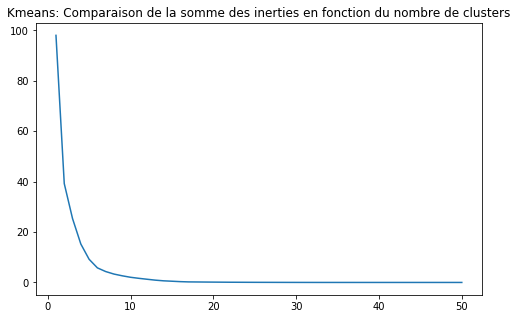

In [204]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
sns.lineplot(list(inertia.keys()),
             list(inertia.values())
            )

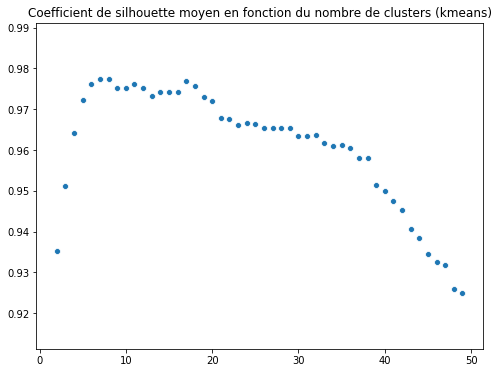

In [205]:
silhouettes_kmeans = {}
for i in range(2,max_clusters):
    silhouettes_kmeans[i] = silhouette_score(X = unsupervised_array,
                                             labels= list(dict_kmeans[i].labels_))

plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(silhouettes_kmeans.keys()),
               y = list(silhouettes_kmeans.values()))
plt.show()



In [206]:
for key, value in silhouettes_kmeans.items():
    if value == max(silhouettes_kmeans.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters_optimal = key

le coefficient de silhouette est maximal pour 8 clusters (score = 0.9774808883666992)


Nombre d'éléments par catégorie

In [ ]:
pd.DataFrame(dict_kmeans[8].labels_)[0].value_counts()

In [208]:
train_labelized = train.copy()
train_labelized['label_kmeans'] = dict_kmeans[nb_clusters_optimal].labels_

In [209]:
train_labelized.groupby(['label_kmeans']).apply(lambda x: (x.groupby('cat_lvl_2')
                                      .count()
                                      .sort_values('cat_lvl_2', ascending=False))
                                     )['uniq_id']

label_kmeans  cat_lvl_2                      
0             Wrist Watches                      110
              Women's Hygiene                      1
              Wall Decor & Clocks                 13
              Tidy Home Furnishing                 1
              Tableware & Cutlery                  3
              Tablet Accessories                   1
              Table Decor & Handicrafts           22
              TRUE Home Decor & Festive Needs      1
              Storage                              1
              Software                             1
              Showpieces                          45
              Showpiece                            4
              Religion & Devotion                  3
              Pressure Cookers & Pans              1
              Network Components                  23
              Makeup                              13
              Living                               3
              Lighting                             4


In [210]:
pd.DataFrame(train, )

uniq_id            crawl_timestamp  \
165   785b4383b12106dd172306d427d8f7b2  2015-12-01 12:40:44 +0000   
248   45d0af2c709de47268c80c35a117de44  2015-12-01 12:40:44 +0000   
310   64b463dc0b75ae40a848498c657041e6  2015-12-01 06:13:00 +0000   
685   6b5cdfe68595fbcab0e05dc625d3d66a  2015-12-31 09:19:31 +0000   
843   e86daf9ebcdfc5c5dd088cdb7f8f8db6  2015-12-29 05:07:38 +0000   
342   17a73d7c4b02ada2bfeed1115fed08a4  2015-12-01 06:13:00 +0000   
605   bcb8e456728013a90ba66ab3b1b783ad  2016-01-07 04:32:43 +0000   
526   9059227d71995f88a1f48ff63830f716  2016-01-07 05:50:25 +0000   
65    2baa415ebcc4fe563ce13b50e60efc1c  2016-06-10 21:33:30 +0000   
631   e40e9b4ae48e452dc407d299b467d0c3  2016-06-07 14:06:00 +0000   
891   463492671c5c19316a0fb9fe1c53da48  2015-12-20 08:26:17 +0000   
254   fda51c31a1b7ae8f3c7b5c0174d3e201  2015-12-01 12:40:44 +0000   
718   b33d82c619bf88c3e3bb8f53beab0c4b  2016-01-01 19:37:22 +0000   
770   63523a600ab69f276664d0eade9d076e  2015-12-12 11:46:53 +0000   
221   81a695f80d3f5c445910d310f1a83eb8  2015-12-01 12:40:44 +0000   
235   e1e133cbe616bee3b3e9e6f4f0882e3d  2015-12-01 12:40:44 +0000   
429   9fb8662af03c957ade34d4c816d4e903  2016-03-11 06:55:07 +0000   
543   d98fac46793639eceaaa2e74cadd4973  2016-01-07 05:50:25 +0000   
440   b90046b67cafcedfd363afba5fafc1c7  2016-04-19 09:52:52 +0000   
588   156bcd3aba1838a2b6bad856654db964  2016-01-07 05:50:25 +0000   
972   729864e0d25e06cbf68561529bcdd4f0  2016-06-14 18:49:44 +0000   
249   0131e5d87b72877702d536299cf83b75  2015-12-01 12:40:44 +0000   
578   5338c00e0ddaec0f3af737077e0bbd91  2016-01-07 05:50:25 +0000   
409   c6cd71c28144224b080cdec222bc4833  2015-12-01 06:13:00 +0000   
71    f2658bad8c2b7d5b08984c6ac34267f7  2016-04-19 05:00:32 +0000   
94    22296bfc1c79d9dc88eabbd01220ef0c  2016-01-04 00:20:04 +0000   
33    b85f8843bb1c297dd5712f0bd287006d  2016-06-12 08:33:38 +0000   
644   68b32e026c109c1bae017d024dd8f590  2016-04-29 11:45:32 +0000   
259   724e6eb7edc83eb48b6492d12e940ebd  2015-12-01 12:40:44 +0000   
204   6775e3b91baa4d368f6d91eb7c24578b  2015-12-01 12:40:44 +0000   
798   9993de7e2bcced43dc9edb3b2c81f23d  2015-12-12 11:46:53 +0000   
620   8a184fe2c82ba6a17fbe07f94d0dd875  2016-03-16 23:37:14 +0000   
365   7bcabeb38f148041087fafdad40e2c57  2015-12-01 06:13:00 +0000   
77    4942e0a9c0527dc00319a39fc8f103e6  2016-03-17 12:56:51 +0000   
84    374e63028d691c380bc43b0dc60e460d  2016-04-30 06:44:11 +0000   
994   fc8ff72b68b0f3736a9aff8f03aa712f  2016-03-23 04:17:35 +0000   
82    601817defaff9d0e30e1b72f96d3975f  2016-03-10 07:45:58 +0000   
525   d21409978f5e404b53f89e444f7893fe  2016-01-07 05:50:25 +0000   
439   26269fd0df12630eec4508c2cf3c94e1  2016-04-19 09:52:52 +0000   
567   97fba8a02361aa56eaa9fa51bc1d7661  2016-01-07 05:50:25 +0000   
560   c205b200b10aab43be31df8fc1db6d86  2016-01-07 05:50:25 +0000   
542   3fa21f35257649e1513ca4ce22c6a68c  2016-01-07 05:50:25 +0000   
887   456ec612b30d4b091639843cdb66bf54  2015-12-20 08:26:17 +0000   
331   f2689f048b3b6f0ff863bf0cce28873d  2015-12-01 06:13:00 +0000   
5     893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
479   209bf06a732416f1ce5147a8b0524808  2016-01-07 05:50:25 +0000   
104   336fc49639a5cc45aa532ace3ee1a044  2016-01-01 10:55:30 +0000   
97    18bd9b88e23b82fd19f8ab0c9cad6a1a  2016-01-04 00:20:04 +0000   
832   078b35be31e8ac99b0cbb817dab4c23f  2015-12-29 05:07:38 +0000   
787   7264f56639c8c54158b94ced769082c8  2015-12-12 11:46:53 +0000   
424   1be8161a259813bca5d068d5730464e7  2016-06-17 07:53:02 +0000   
934   43da6e88dcb61e027ea9112cfab158ee  2016-01-01 13:15:34 +0000   
281   db3e2eeb4fe90d4755f2911d661eae95  2016-04-24 18:34:50 +0000   
266   0e73201f6d8807776e1d21c969078289  2015-12-01 12:40:44 +0000   
534   4019ad332ca3ce22449ff54fdd49a273  2016-01-07 05:50:25 +0000   
453   e6b483fce5fd910afda67d97dc04e775  2015-12-03 21:49:05 +0000   
359   4b0e6f200426b1db8824b2ca0c59ecfa  2015-12-01 06:13:00 +0000   
490   9a8fa4fd6524ada03411b03

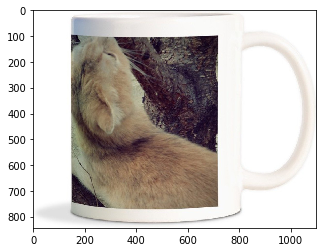

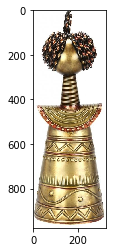

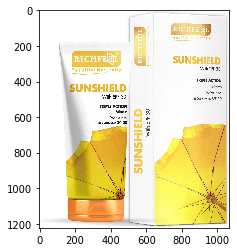

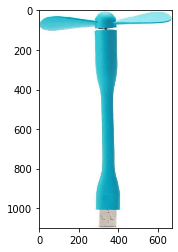

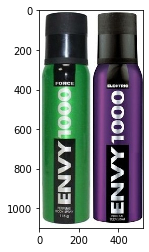

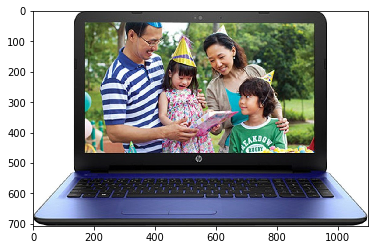

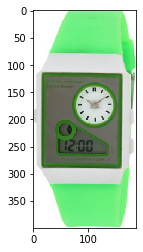

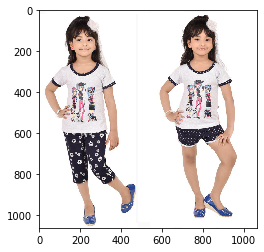

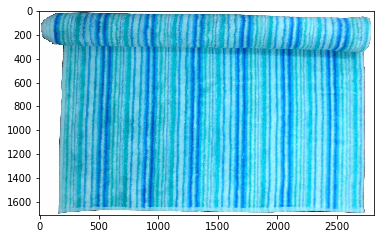

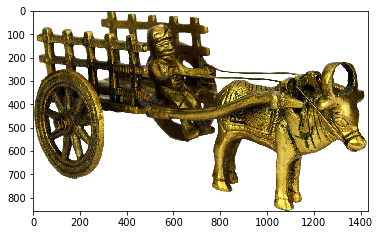

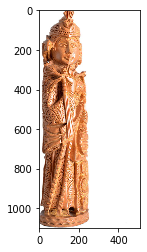

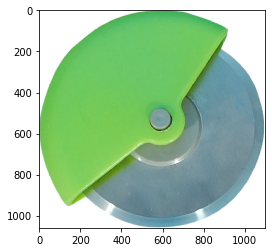

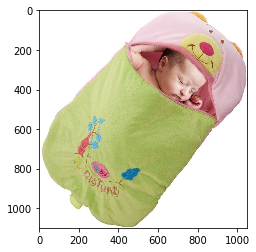

In [230]:
%matplotlib inline
k = 0
for image in train_labelized[train_labelized['label_kmeans'] == 0]['image'].tolist():
    if k < 20:
        chemin = image
        plt.figure()
        plt.imshow(Image_PIL.open(chemin))
        plt.show()
        k+=1
    else:
        break

# Fin du projet : Voir notebook 2

En raison de problèmes de mémoire vive sur mon ordinateur empêchant d'exécuter le notebook dans son intégralité, la fin du projet est présentée dans un notebook séparé.

# Annexe : Check mémoire

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
pd.DataFrame(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

In [ ]:
%reset_selective train_array_cnn

In [ ]:
#%reset_selective -f [image_essai, im, im2, array_image, ech, data_visuelle]